# **MATH&ML-8. Алгоритмы на основе деревьев решений**

# 1. Введение

✍ Настало время поговорить о деревьях. Но не о тех, что растут в лесу, а об алгоритме машинного обучения под названием **дерево решений (decision tree)**.

Саму модель дерева решений мы уже использовали, решая множество различных задач машинного обучения: от определения наличия диабета у пациента до предсказания длительности поездок на такси. Но задавались ли вы вопросом, как работает эта модель с точки зрения математики? Настало время это выяснить.

![](https://lms.skillfactory.ru/assets/courseware/v1/fa4b1d79761eab8b26e7bdc5357a7888/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_1_1.png)

**В этом модуле мы:**

* разберёмся с математической «магией», которая скрывается за алгоритмом построения дерева решений;
* узнаем, как деревья работают в задачах обучения с учителем;
* своими руками реализуем алгоритм построения дерева решений.

Для того чтобы познакомиться с деревьями решений, нам очень понадобятся знания, полученные в модулях по математическому анализу и теории вероятностей, так как древовидные модели используют именно этот математический аппарат.

In [1]:
1/5*(5 + 13 - 18)**2 + 1/8*(13-5)

1.0

### Задание 1.9

Была построена модель машинного обучения, которая решает задачу классификации файлов на безопасные (класс 0) и вирусные (класс 1). После валидации модели на 100 наблюдениях была получена следующая матрица ошибок:

-|$\hat{y}=0$|$\hat{y}=1$
-|-|-
$y=0$|73|13
$y=1$|4|10

Здесь $y$ — истинные классы файлов в валидационной выборке, а $\hat{y}$ — предсказания модели.

Рассчитайте условную вероятность того, что файл является вирусным, при условии, что модель посчитала файл вирусным: $P(y=1|\ \hat{y}=1)$. Иначе говоря, рассчитайте метрику precision для обученной модели. Ответ округлите до двух знаков после точки-разделителя.

In [2]:
# P(B|A) = P(A/B) / P(A)
round(0.1/0.23, 2)

0.43

⭐ Поздравляем — вы справились с вопросами по пройденному материалу, а значит мы можем начать исследовать деревья от корней до самых листьев.

Если у вас возникли трудности с прохождением входного тестирования, рекомендуем вам заглянуть в модули MATH&ML (4-7) и ещё раз изучить основы математического анализа и теории вероятностей, в частности — повторить работу со множествами, понятие функции, исследование функций, а также определение вероятности, условной вероятности и основные типы распределений.

Для начала по традиции поставим себе **цели на модуль**:

* изучить основную терминологию деревьев решений, их область применения, преимущества и недостатки;
* понять принцип решения задач классификации и регрессии с помощью деревьев решений;
* рассмотреть алгоритм построения деревьев решения CART;
* изучить понятия неоднородности и критерия информативности;
* рассмотреть критерии остановки ветвления дерева и научиться с их помощью управлять сложностью модели;
* научиться осмысленно решать задачи регрессии и классификации с помощью деревьев решений и алгоритмов, основанных на них.

Итак, начнём наше погружение в «дендрологию машинного обучения» →

# 2. Деревья решений в контексте задач классификации и регрессии

✍ С общими представлениями о модели дерева решений мы знакомились, когда изучали задачу классификации (ML-3. Обучение с учителем: классификация). Это неслучайно, ведь изначально деревья решений создавались именно для решения этой задачи. Чуть позднее оказалось, что алгоритм может быть запросто адаптирован и для решения задач регрессии.

В этом модуле мы будем рассматривать деревья решений параллельно в контексте задач классификации и регрессии. Демонстрация работы алгоритма на обеих задачах позволит нам посмотреть на картину в целом и наглядно покажет сходства и различия моделей. Забегая вперёд, скажем, что алгоритмы построения дерева решений для задач классификации и регрессии отличаются лишь в паре шагов.

Для начала мы посмотрим, что вообще представляет собой обученное дерево решений, и заодно закрепим «древесную» терминологию, с которой знакомились ранее, — она будет нас сопровождать на протяжении всего модуля.

Так как мы находимся в разделе MATH&ML, то и говорить будем на строгом математическом языке, но при этом будем сопровождать свои рассуждения переводом на «человеческий».

Начнём с постановки задачи машинного обучения — для этого рассмотрим конкретный **пример**, а затем обобщим его с помощью математического аппарата.

*У нас есть набор из 500 объектов, которые описываются пятью какими-то характеристиками. Например, это могут быть 500 пациентов, у которых измерили пять медицинских параметров: вес, рост, давление, количество лейкоцитов в крови и уровень сахара.*

*В паре с объектом всегда идёт целевая переменная, которую необходимо научиться предсказывать. Например, целевой переменной может быть признак болезни: 1 — болен диабетом, 0 — не болен диабетом.*

*Наша цель — построить модель машинного обучения, которая на основе характеристик объекта предсказывает целевую переменную. Для нашего примера это будет модель, которая на основе медицинских параметров выдаёт свой прогноз о наличии у пациента диабета.*

Это была классическая постановка задачи машинного обучения в свободной форме. Давайте теперь посмотрим, как будет выглядеть та же самая задача на языке математики.

**Примечание.** Далее для простоты изложения и упрощения обозначений мы не будем писать стрелки над векторами. Если какая-то переменная будет являться векторной, мы будем указывать на это в явном виде.

Постановка задачи машинного обучения может выглядеть по-разному. Например, когда мы разбирали линейные модели в модулях по линейной алгебре, мы давали постановку задачи на языке линейной алгебры. От нас требовалось линейно выразить целевой вектор $y$ через векторы-факторы $x_j$. 

В контексте разговора о деревьях нам будет удобнее использовать не чистый аппарат линейной алгебры, а совместить его с теорией множеств.

Пусть задано обучающее множество пар объектов и ответов к ним $Q=\{(x,\ y)\}$, где $x\ \in \ X$ — векторы из $\mathbb{R}^M$, описываемые $M$ координатами (признаками), $y\ \in \ Y$ — целевая метка объекта, $\left|Q \right|=N$. Множество $Y$ может быть непрерывным (задача регрессии) с мощность $\left|Y \right|=N$ или дискретным (задача классификации) с мощностью $\left|Y \right|=K$, где $K$ — количество классов.

В примере выше:

* $x=(x_1,\ x_2,\ x_3,\ x_4,\ x_5)$ — один отдельный пациент;
* $x_j$ — признак (фактор), описывающий его;
* $X$ — множество всех пациентов;
* $N = 500$ — количество пациентов;
* $M = 5$ — количество признаков, описывающих пациентов;
* $Y=\{0, 1\}$ — множество уникальных классов объектов;
* $K=2$ — количество классов (мощность множества $Y$).

**Наша цель** — составить такую функцию/модель $f(x)$, которая наилучшим образом определяет зависимость между векторами $x$ из множества $X$ и целевой переменной $y$ из множества $Y$ — $f:X\to Y$.

Строго говоря, такую функцию мы будем искать не в аналитическом виде, как мы делали, например, в случае линейной регрессии, а в виде алгоритма, то есть в виде последовательности действий. Обычно в математике алгоритм обозначается как $a(x)$ или $a:X \to Y$.

![](https://lms.skillfactory.ru/assets/courseware/v1/0e70f465c22d4b4ab68168baf24c268e/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_1.png)

Алгоритм $a(x)$ мы будем искать в семействе деревьев решений.

## ОПРЕДЕЛЕНИЕ РЕШАЮЩЕГО ДЕРЕВА

> Если говорить простыми словами, **обученное дерево решений** — это последовательность вопросов, которые задаются поступающим на его вход объектам.

Например:

* «Рост  170 м?» 
* «Вес  60 кг?»
* «Содержание сахара  70 мг/дл?»

В зависимости от того, выполняется ли заданное в вопросе условие, объект переходит к одному из следующих вопросов, и так происходит до тех пор, пока не будет получен конечный результат — прогноз дерева решений для данного объекта. Всё это очень напоминает стандартные рассуждения по принципу «если…, то».

В качестве примера дерева решений в текстовом виде приведём процесс принятия решения о том, куда поехать в отпуск.

* Если «бюджет  1000 $»:
    * Если «продолжительность отпуска  пяти дней»:
        * Едем на дачу
    * Если «продолжительность отпуска > пяти дней»:
        * Едем в Кисловодск
* Если «бюджет > 1000 $»:
    * Если «продолжительность отпуска  десяти дней»:
        * Едем в Сочи
    * Если «продолжительность отпуска > десяти дней»:
        * Едем в Египет
        
Последовательность вопросов можно оформить в виде вершин графа, структура которого будет напоминать перевёрнутое дерево.

Пройдя путь, который зависит от характеристик объекта, через последовательность от первого вопроса (корня дерева) до финального ответа (листа) мы можем определить значение целевой переменной. В задаче регрессии финальный ответ дерева — некоторое число, а в задаче классификации — класс объекта.

![](https://lms.skillfactory.ru/assets/courseware/v1/470cb9d62cbda001180f0dafdfd6004c/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_2.png)

Давайте переведём вышесказанное на более формальный язык математики, на котором, собственно, и работает программная реализация дерева решений.

> **Дерево решений** представляет собой последовательность условий вида $x_j\le t$, которые называются **предикатами**, или **решающими правилами**.

Формально сами предикаты в вершинах мы ранее обозначали как:

$$B_{\nu }(x_j,\ t)\ =\ I[x_j\le t],$$

где $\nu$ — номер вершины графа, а $I$ с квадратными скобками $[]$ — обозначение индикаторной функции (она равна 1 (True), если условие внутри скобок выполняется, и 0 (False) — в противном случае).

**Примечание**. Далее для удобства мы будем обозначать индикаторную функцию $I$ простыми квадратными скобками, например:

$$B_{\nu }(x_j,\ t)\ =\ [x_j\le t]$$

Каждый предикат разделяет множество объектов $X$ на два подмножества:

* левое — множество тех объектов, для которых заданное в предикате условие выполняется: $X^{left}=\{x\ |\ x_j\le t\}$;
* правое — множество тех объектов, для которых условие ложно: $X^{right} = X \backslash X^{left} = \{x \mid x_j > t \}$.

Последовательность предикатов лучше всего представлять в виде **ациклического связного графа**. 

Давайте посмотрим на пример такого графа для дерева решений глубиной 4. Дерево решает задачу классификации 15 наблюдений (мощность множества $X$) на три класса (мощность множества $Y$):

![](https://lms.skillfactory.ru/assets/courseware/v1/67d61bcfc998e0c2af988c222497fd63/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_3.png)

**Примечание**. Информация, указанная в вершинах графа, определяется во время обучения дерева решений, о процедуре которого мы поговорим в следующих юнитах:

* $x_j\le t$ — условие предиката;
* gini — значение критерия информативности (в данном случае используется критерий Джини);
* samples — число объектов из обучающей выборки, попавших в вершину;
* value — число объектов каждого из классов из обучающей выборки, попавших в вершину.

В построенном графе выделяют **три типа вершин**:

* корневая вершина (root node) — то, откуда всё начинается;
* внутренние вершины (intermediate nodes);
* листья (leafs) — конечные вершины дерева, в которых определяется конечный «ответ» — прогноз дерева решений.

![](https://lms.skillfactory.ru/assets/courseware/v1/7b0c9b8ff0219ff9f5a63ae3bb1dc95d/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_4.png)

Вершины графа группируются в уровни, которые называются **глубиной дерева (depth)**. Отсчёт уровней ведётся с 0 (то есть корневая вершина не считается при подсчёте глубины дерева).

Корневая и внутренние вершины содержат предикаты $B_{\nu }(x_j,\ t)$, на основе которых организуется движение по графу. В ходе предсказания осуществляется проход по дереву к некоторому листу. Для каждого объекта из выборки движение начинается из корня.

В вершине $v$ проход осуществляется вправо, если для объекта $x$ условие, записанное в предикате, выполняется, то есть $B_{\nu }(x_j,\ t)=1$, и влево, если условие является для объекта $x$ ложным, то есть $B_{\nu }(x_j,\ t)=0$. Проход продолжается до момента, пока будет достигнут некоторый лист. Ответом алгоритма для объекта $x$ считается прогноз $\hat{y}=a(x)$, приписанный этому листу.

В задаче **регрессии** прогноз целевой переменной $\hat{y}$ будет определяться принципом усреднения, то есть объекту $x$ в качестве прогноза присваивается среднее (или медианное) значение целевой переменной по объектам, попавшим в лист на этапе обучения дерева.

В задаче **классификации** прогноз целевой переменной $\hat{y}$ будет определяться принципом голосования большинства, то есть объекту $x$ присваивается самый популярный класс объектов, попавших в лист на этапе обучения дерева.

Давайте посмотрим, как введённые нами математические обозначения работают на **примере** построенного графа ↓

![](https://lms.skillfactory.ru/assets/courseware/v1/67d61bcfc998e0c2af988c222497fd63/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_5.png)

Пусть появился новый объект . Ещё раз напомним, что под переменной  может скрываться всё что угодно: пациент, автомобиль, клиент банка и т. д.

$x=(x_1,\ x_2,\ x_3,\ x_4)=(1,\ 1,\ 1,\ 0)$

Этот объект представляется в виде четырёхмерного вектора-строки. Пусть он будет иметь следующий вид:

Каждая координата вектора $x$ — это некоторая характеристика объекта, например, вес, рост, давление и т. д.

Необходимо определить прогноз дерева решений — класс объекта $\hat{y}=a(x)$. Классы обозначены метками от 0 до 2.

Номер вершины $v$ будем определять в формате $ij$, где $i$ — глубина дерева, а $j$ — номер вершины на -й глубине слева-направо (если таких вершин несколько). Номер корневой вершины традиционно обозначается за $v=0$.

Смотрим на первую (корневую) вершину нашего графа. В ней записан предикат:

$B_0(x_j=x_2,\ t=1.5)=[x_2\le 1.5]$

Определяем значение предиката $B_0$ для нашего объекта $x$:

$B_0=[x_2\le 1.5]=[1\le 1.5]=1$

Так как $B_0=1$, то мы переходим из этой вершины в левую ветвь дерева — в вершину под номером $v=11$.

Предикат в следующей вершине ($B_{11}$) имеет вид:

$B_{11}(x_j=x_4,\ t=0.5)=[x_4\le 0.5]$

Определяем значение предиката $B_{11}$ для нашего объекта $x$:

$B_{11}=[x_4\le 0.5]=[0\le 0.5]=1$

Так как $B_{11}$, то мы снова переходим из этой вершины в левую ветвь дерева — в вершину под номером $v=21$.

Предикат в следующей вершине ($B_{21}$) имеет вид:

$B_{21}(x_j=x_2,\ t=0.5)=[x_2\le 0.5]$

Определяем значение предиката $B_{21}$ для нашего объекта $x$:

$B_{21}=[x_2\le 0.5]=[1\le 0.5]=0$



Так как $B_{21}=0$, то мы переходим из этой вершины в правую ветвь дерева — в вершину под номером $v=32$.

Вершина дерева под номером $v=32$ не содержит предиката, так как является листовой. Она содержит информацию о количестве объектов каждого из классов в обучающей выборке (список value): $[0,0,3]$. То есть при обучении дерева в вершину под номером $v=32$ попало по 0 объектов классов «0» и «1» и три объекта класса «2».

Можно визуализировать наш путь по графу:

![](https://lms.skillfactory.ru/assets/courseware/v1/8680ca6c29d779af9b109193f5bcc378/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_6.png)

Класс объекта будет определён как наиболее популярный в конечной вершине, то есть:

$\hat{y}=a(x)=argmax([0,\ 0,\ 3])=2$

## ГЕОМЕТРИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ ДЕРЕВА РЕШЕНИЙ

Теперь поговорим о том, что значит решить задачу регрессии/классификации с помощью дерева решений с точки зрения геометрии.

Геометрически каждый предикат $B_v(x_j,\ t)=[x_j\le t]$ задаёт в пространстве факторов разделяющую плоскость. Эта плоскость всегда будет перпендикулярна оси фактора $x_j$ и будет делить пространство факторов на две части: ту, для которой условие $x_j\le t$ выполняется, и ту, для которой это условие ложно. 

Следующие предикаты будут делить каждую из образованных при прошлом разделении областей на две другие части и так далее, пока не будут образованы листовые вершины.

В результате построения дерева решений мы получаем пространство факторов, разделённое на $l$ областей, каждая из которых соответствует своей листовой вершине. Обозначим эти области как $R_p, p=1,\ 2,...,\ l$.

В случае, когда фактор всего **один**, то есть объект $x\in \ X$ является двухмерным вектором из пространства действительных чисел , вся числовая ось фактора $x_1$ разбивается на отрезки. Пример такого случая представлен ниже:

![](https://lms.skillfactory.ru/assets/courseware/v1/8bec8d6535de222d7743f17d9ca79389/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_9.png) 

![](https://lms.skillfactory.ru/assets/courseware/v1/7928c5fc6d0d047c241437046eb53729/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_9_1.png)

В случае, когда факторов только **два**, то есть объект $x \in X$ является двухмерным вектором из пространства $\mathbb{R}^2$, всё пространство факторов будет разбито на прямоугольные области. Пример такого случая представлен ниже:

![](https://lms.skillfactory.ru/assets/courseware/v1/bc284f60292fe5ff1d13d841718df359/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_10.png)

![](https://lms.skillfactory.ru/assets/courseware/v1/86a755d6b2b2d49ab503d1c24df06994/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_10_1.png)

В случае, когда в нашем распоряжении есть **три** фактора, то есть объект $x \in X$ является двухмерным вектором из пространства $\mathbb{R}^3$, мы получаем трёхмерное пространство, разделённое на параллелепипеды. Пример:

![](https://lms.skillfactory.ru/assets/courseware/v1/4ecca772dee88a49b74ad3fb381fa575/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_11.png)

![](https://lms.skillfactory.ru/assets/courseware/v1/1c3ff4fbc0f885c675e6bdec9971469f/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_11_1.png)

В общем случае, когда факторов $m$ штук, то есть объект $x \in X$ является вектором из пространства $\mathbb{R}^m$, мы получаем $m$-мерное пространство, разбитое на области, представляющие собой $m$-мерные параллелепипеды или, как их называют в математике, гиперпараллелепипеды.

**В случае задачи регрессии (Decision Tree Regressor)** ответ модели (значение целевого признака) будет определяться как среднее значение целевой переменной $y$ внутри области $R_p$, соответствующей листовой вершине. Математически это записывается следующим образом:

$$\hat{y}=a(x)=\frac{1}{\left|R_p \right|}\sum_{y \ \in \ R_p}{}y$$

**Примечание.** Запись $\sum_{y\ \in \ R_p}$ здесь означает, что значение $y$ для суммирования берётся для тех объектов, которые принадлежат множеству $R_p$, то есть сумма считается только для тех объектов, которые попадают в область, обозначенную как $R_p$.

Давайте посмотрим на **пример** разделяющей поверхности дерева решений в случае задачи регрессии ↓



Воспользуемся данными о недвижимости в штате Айова из [Ames Housing Dataset](https://www.kaggle.com/datasets/prevek18/ames-housing-dataset). Это классическая задача предсказания цены недвижимости, которую мы уже решали не раз с различными датасетами.

Для примера визуализации из всех признаков, описывающих объекты недвижимости, мы выберем:

* Lot_Frontage — ширина фасада;
* Lot_Area — площадь объекта недвижимости.

Необходимо предсказать стоимость недвижимости (Sale_Price). Файл с данными вы можете скачать [здесь](https://lms.skillfactory.ru/assets/courseware/v1/6540af69ab90af826cd1c8e60a709ea3/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/AmesHousing.zip).

![](https://lms.skillfactory.ru/assets/courseware/v1/c84bad23d72839406e70e9dfc91704af/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_12.png)

Для начала импортируем необходимые библиотеки:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

Как обычно, подготовим обучающую выборку, отделив факторы X и целевую переменную y:

Примечание. Для более понятной визуализации перед построением дерева уберём из датасета объекты с Lot_Frontage > 150 и с Lot_Area > 20000.

In [4]:
# Создаём обучающую выборку
ames_data = pd.read_csv('data/AmesHousing.zip')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
X = ames_data[['Lot Frontage', 'Lot Area']]
y = ames_data['SalePrice']

Создадим модель дерева решений для задачи регрессии с максимальной глубиной 3 и обучим её. Напомним, что в sklearn за реализацию дерева решений для задачи регрессии отвечает класс [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) из модуля tree.

In [5]:
# Инициализируем модель дерева решений с максимальной глубиной 3 и обучаем её
dt_reg = tree.DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X.values, y)

DecisionTreeRegressor(max_depth=3)

Отследить, как дерево решений строит свой прогноз, нам может помочь граф обученного дерева решений. Напомним, что за его визуализацию в библиотеке sklearn отвечает функция [plot_tree()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) из модуля tree.

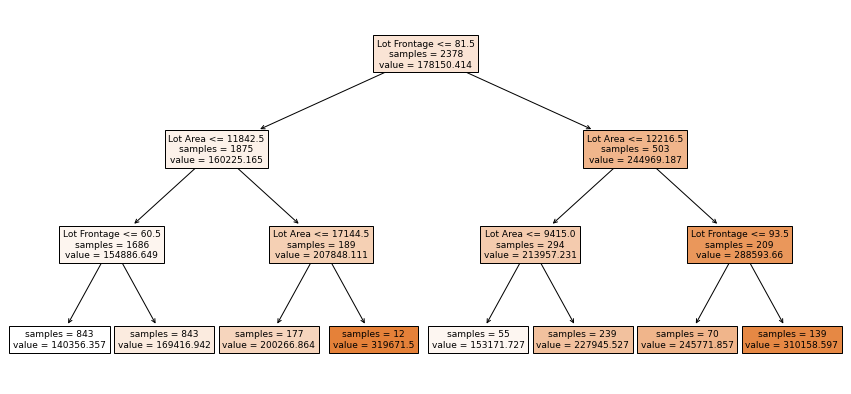

In [6]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_reg, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

Построим диаграмму рассеяния и визуализируем то, как дерево решений разделяет пространство факторов на прямоугольные области. Для этого шага мы реализовали функцию plot_decision_bound_regression():

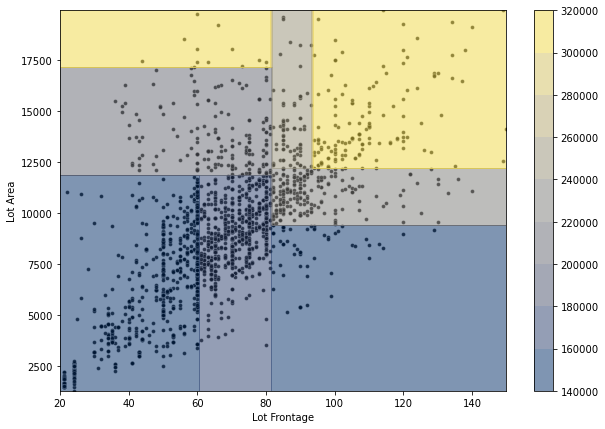

In [7]:
def plot_decision_bound_regression(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    y_pred = model.predict(X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)

# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_regression(X, y, dt_reg, fig)

Что мы здесь видим? В результате построения дерева решений было образовано восемь областей ($R_1, R_2,..., R_8$), соответствующих каждому из восьми листьев. В каждой из областей было рассчитано предсказание дерева для этой области  — среднее арифметическое целевой переменной $y$ (они отражены на тепловой шкале справа от диаграммы) по формуле, приведённой выше.

Прогноз для нового объекта будет определяться в зависимости от того, в какую из полученных областей он попадёт.

**В случае задачи классификации (Decision Tree Classifier)** ответ модели (класс объекта) будет определяться голосованием большинства внутри области $R_p$, то есть дерево будет возвращать тот класс, который наиболее популярен в области $R_p$, соответствующей листовой вершине.

Как записать это в виде формулы? Необходимо вычислить оценку вероятности принадлежности объекта к каждому из классов $p_k$.

Вспомним, что вероятность — это количество положительных исходов (количество объектов класса под номером $k$ в области $R_p$), делённое на общее количество исходов (общее количество объектов в области $R_p$).

Формула оценки вероятности принадлежности объекта к -му классу будет иметь следующий вид:

$$P_k=\frac{1}{\left|R_p \right|}\sum_{y\ \in \ R_p}{}[y=k],$$

где $[]$ — индикаторная функция, а $\left|R_p \right|$ обозначает мощность множества объектов, находящихся в области $R_p$, то есть их количество. После некоторых размышлений становится ясно, что сумма $\sum_{y\ \in \ R_p}{}[y=k]$ здесь будет расшифровываться как «количество объектов из области $R_p$, принадлежащих к классу $k$».

Тогда сам класс объекта $\hat{y}$ определяется как класс с максимальной из вероятностей. Математически это будет выглядеть так:

$$\hat{y}=a(x)=argmax_{k\in K}(P_k)$$

Давайте посмотрим на пример разделяющей поверхности дерева решений в случае задачи классификации ↓

Воспользуемся данными о банкнотах из [Banknote Authentication Dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication).

**Примечание**. Данные были получены из изображений, которые соответствуют подлинным и поддельным образцам банкнот. Для оцифровки использовалась промышленная камера, обычно используемая для проверки отпечатков. Конечные изображения имеют размер 400x400 пикселей. 

Далее эти изображения были подвергнуты специальному **вейвлет-преобразованию**. Это преобразование, которое позволяет закодировать изображение в виде набора чисел. Если вам интересно подробнее изучить эту тему, рекомендуем прочесть [данную статью](https://habr.com/ru/post/168517/).

Из преобразованных данных были извлечены различные статистические характеристики.

В качестве примера для визуализации из всех характеристик, описывающих изображения банкнот, будем использовать:

* Variance (дисперсию);
* Skewness (асимметрию).

**Наша цель** — предсказать, является ли банкнота фальшивой (Class): 1 — фальшивая, 0 — подлинная. Файл с данными вы можете скачать [здесь](https://lms.skillfactory.ru/assets/courseware/v1/bece701a8a7cdf826c3487a3b2b0044b/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/bill_authentication.zip).

Как обычно, подготовим обучающую выборку, отделив факторы X и целевую переменную y:

In [8]:
# Создаём обучающую выборку    
bill_data = pd.read_csv('data/bill_authentication.zip')
X = bill_data[['Variance', 'Skewness']]
y = bill_data['Class']

Создадим модель дерева решений для задачи регрессии (класс [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) из модуля tree библиотеки sklearn) с максимальной глубиной 4 и обучим её.

In [9]:
# Инициализируем модель дерева решений с максимальной глубиной 4 и обучаем её
dt_clf = tree.DecisionTreeClassifier(max_depth=4)
dt_clf.fit(X.values, y)

DecisionTreeClassifier(max_depth=4)

Отследить то, как дерево решений строит свой прогноз, нам может помочь граф обученного дерева решений:

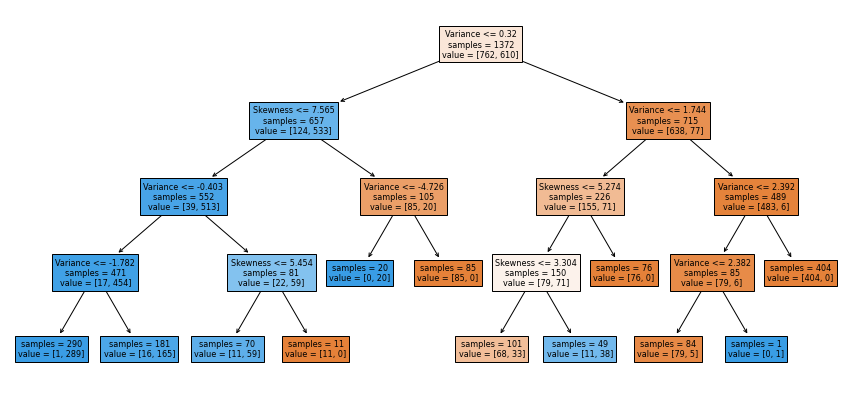

In [10]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_clf, #дерево решений
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

Построим диаграмму рассеяния и визуализируем то, как дерево решений разделяет пространство факторов на прямоугольные области. Для этого шага мы реализовали функцию функцию plot_decision_bound_classification():

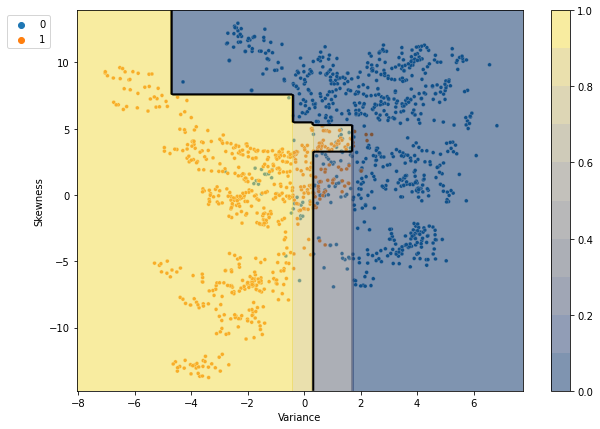

In [11]:
def plot_decision_bound_classification(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    probs = model.predict_proba(X_net)[:, 1]
    probs = probs.reshape(xx1.shape)
    
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, s=15, alpha=1)
    contour = plt.contourf(xx1, xx2, probs, 10, cmap='cividis', alpha=0.5)
    bound = plt.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    fig.colorbar(contour)
    plt.legend(bbox_to_anchor=(-0.05, 1))
# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_classification(X, y, dt_clf, fig)

В результате построения дерева было образовано 12 областей ($R_1, R_2,..., R_{12}$), каждая из которых соответствует одному из 12 листьев. В каждой из областей была рассчитана оценка вероятности принадлежности к каждому из классов — $P_k$. Класс объекта $\hat{y}$ определяется как класс с максимальной из этих вероятностей. Выше представлена тепловая карта вероятностей принадлежности к классу фальшивых банкнот — $\hat{P_1}$ (они отражены на тепловой шкале справа от диаграммы — области, для которых вероятности закрашены одинаковым цветом). Банкноты, для которых данная вероятность $P_1>0.5$, дерево считает фальшивыми, а остальные — подлинными.

В заключение по геометрии давайте посмотрим на пример того, как будет выглядеть геометрическая интерпретация прогноза дерева решений в случае построении регрессии целевой переменной $y$ в зависимости только от одного фактора $x_1$.

На графиках ниже представлены предсказания модели дерева решений $\hat{y}$ с различной глубиной. Для примера зависимости $y$ от $x_1$ возьмём параболу с добавленным в неё случайным шумом $\varepsilon$:

$$y={x^2}_1+\varepsilon$$

![](https://lms.skillfactory.ru/assets/courseware/v1/ab0e4197be03d5e9c27dca34d82450df/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_18.png)

Видно, что прогнозом дерева $\hat{y}$ будет ступенчатая кусочно-постоянная функция. Каждая ступенька — это среднее значение целевой переменной $y$ на участке, соответствующем листовой вершине дерева. Легко понять, что чем больше глубина дерева, тем больше в нём листьев, а значит будет больше участков и прогноз на обучающей выборке с помощью среднего будет получаться точнее, что видно на графике справа.

## СВОЙСТВА АЛГОРИТМА ДЕРЕВА РЕШЕНИЙ

Подведём промежуточный итог. В начале юнита мы обозначили нашу глобальную цель — найти такую функцию $a(x)$, которая связывает два множества $X$ (множество объектов) и $Y$ (множество примеров).

Задав структуру дерева решений, а также решающие правила $B_v(x_j,\ t)$ в каждой из вершин, мы решим нашу задачу. Полученное дерево как раз и станет нашей функцией $a(x)$.

Да, дерево решений — это не классическая для нас аналитическая функция, как $x^2$ или $e^x$, к которым мы привыкли, решая задачи в модулях по математическому анализу. Это отдельный вид функций, представленных в виде последовательности действий — алгоритма.

Схематично связь между множествами $X$ и $Y$ можно представить следующим образом:

![](https://lms.skillfactory.ru/assets/courseware/v1/82a586e644feb49d896cd0205830b511/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_21.png)

Из структуры дерева решений следует **несколько интересных свойств:**

1. Полученная функция $$ является кусочно-постоянной, а у таких функций производная равна нулю во всех точках, где задана функция. Следовательно, при поиске оптимального решения можно забыть о градиентных методах, таких как SGD.

2. В случае задачи регрессии дерево решений (в отличие от, например, линейной регрессии) не может предсказывать значения целевой переменной за границами области значений обучающей выборки (на самом деле может, но для этого нужны специальные манипуляции над данными, которые не входят в рамки данного модуля).

    В качестве примера посмотрим на поведение функции синуса. Ещё со школы мы знаем, что синус бесконечный и периодический, то есть его значения перемещаются в диапазоне от $-1$ до $1$ с каким-то периодом (период синуса равен $2\pi$). Посмотрим, что на это скажет дерево решений.

    Предположим, что у нас есть 200 точек на отрезке $x\in [0,\ 20]$. Посчитаем в них значение синуса, добавив к результату для правдоподобности некоторый случайный шум $\varepsilon$:

    $y=sin(x)+\varepsilon$

    В качестве обучающей выборки возьмём первые 100 точек из отрезка от $0$ до $10$ и обучим на них дерево решений. Затем сделаем предсказание целевой переменной, но теперь уже для всех 200 точек из отрезка от $0$ до $20$ и визуализируем результат. Получим следующую картину:

    ![](https://lms.skillfactory.ru/assets/courseware/v1/086234d6144eb6a83bdc16847133198b/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_22.png)

    Видно, что дерево решений хорошо описывает поведение синуса на отрезке от $0$ до $10$, однако будущие значения на отрезке от $10$ до $20$ модель уже не может предсказать корректно.

3. Дерево решений способно идеально приблизить обучающую выборку, но при этом ничего не выучить: для этого достаточно построить такое дерево, в каждый лист которого будет попадать только один объект.

    Такая модель будет обладать идеальным качеством на обучающей выборке, однако при её использовании на реальных данных качество будет низким. Иначе говоря, модель будет переобученной.

    Приведём примеры того, как будут выглядеть переобученные деревья решения:

    ![](https://lms.skillfactory.ru/assets/courseware/v1/ecbf892a409cedd33d146e5172d1583e/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_23.png)

    В задаче **регрессии** мы выделили для каждого наблюдения из обучающей выборки (жёлтые точки на графике) свои отдельные листья. В результате мы получили очень сложную ступенчатую функцию, проходящую через каждую жёлтую точку. Однако эта функция совершенно не отражает общей зависимости и значение ошибки прогноза этой модели на тестовых данных (чёрные точки) будет гораздо выше.

    ![](https://lms.skillfactory.ru/assets/courseware/v1/245c3ad0eed74d9f1e0210a2fcb185b7/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_2_24.png)

    В задаче **классификации** мы разделили пространство факторов так, что в каждую из областей попали объекты только одного класса. Эти прямоугольные области получились очень сложными и опять же не отражающими общей зависимости.

# 3. Алгоритм CART: параметры разбиения

✍ Теперь, когда мы посмотрели, что представляет собой обученное дерево решений, давайте разберёмся, как происходит сам процесс построения модели.

МЕТОДЫ ПОСТРОЕНИЯ ДЕРЕВА РЕШЕНИЙ. АЛГОРИТМ CART

Существует несколько стратегий построения деревьев решений, но для нас будет представлять интерес только одна из них — алгоритм CART. Для особо любознательных мы собрали краткий список основных стратегий и указали их основные отличия друг от друга.

#### Основные алгоритмы построения деревьев и их отличия

* ID3 (Iterative Dichotomiser 3) был разработан Джоном Куинланом (как и два последующих алгоритма) в 1986 году. Алгоритм создаёт многостороннее дерево, находя для каждого узла категориальный признак, который даст наибольший информационный выигрыш. Деревья вырастают до максимального размера, а затем обычно применяется этап обрезки, чтобы улучшить обобщающую способность деревьев и избежать переобучения.

    Ограничения алгоритма:
    
    * все факторы должны быть категориальными;
    * предназначен для решения задач классификации.  
.                
* C4.5 — алгоритм-преемник ID3. Он снимает ограничение, что факторы обязательно должны быть категориальными, путём разбиения непрерывного числового фактора на дискретный набор интервалов. C4.5 преобразует обученные деревья в наборы правил «если, ... то». Затем оценивается точность каждого правила, чтобы определить порядок, в котором они должны применяться.
* C5.0 — последняя лицензированная версия алгоритма. C5.0 использует меньше памяти и создаёт меньшие наборы правил, чем C4.5, но при этом является более точным.

> **CART (Classification and Regression Tree)** — это алгоритм, предназначенный для построения бинарных деревьев решений. Он очень похож на C4.5, однако, в отличие от последнего, предназначен как для задач классификации, так и для задач регрессии. CART важен для нас, поскольку именно он используется для построения моделей решающих деревьев в sklearn.

Далее мы увидим, что CART строит деревья, используя факторы и пороговые значения, которые дают наилучшее уменьшение неоднородности (неопределённости) или, иначе говоря, наибольший прирост информации в каждой вершине дерева.

Разбирать алгоритм мы будем по частям на простых примерах, а затем сложим их все воедино. Итак, начнём ↓

Пусть у нас есть множество наблюдений $x \in X$ и правильных ответов к ним $y \in Y$. 

Для конкретики рассмотрим «игрушечный» набор данных, состоящий из десяти наблюдений ($N=10$) и двух факторов ($M=2$). $x_1$ — возраст клиента (age), $x_2$ — доход клиента в тысячах рублей (income). То есть множество $X$ - это множество клиентов банка. Целевой переменной $y$ является признак дефолта заёмщика: 0 — кредит был погашен (loan), 1 — кредит не был погашен (not loan). Таким образом, множество $Y=\{0, 1\}$.

![](https://lms.skillfactory.ru/assets/courseware/v1/a851c322b75f537d66dbf94c5e31a11e/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_3_1.png)

Нам необходимо построить алгоритм $a(x)$ — дерево решений, которое для клиентов из множества $X$ выдаёт ответ из множества $Y$ (выплатит ли заёмщик кредит).

По опыту работы с линейной регрессией мы знаем, что у моделей всегда есть внутренние параметры, которые мы пытаемся оптимизировать так, чтобы ошибка между ответами и предсказаниями на обучающей выборке была наименьшей. Обозначим эти параметры буквой $w$. 

Для начала разберёмся, что является внутренними параметрами дерева.

> Под **внутренними параметрами** $w$ понимается структура дерева, а именно последовательность предикатов $B_v(x_j,\ t)=[x_j\le t]$ и сами параметры $j$ (номер признака, по которому строится условие в предикате) и $t$ (пороговое значение для условия), то есть $w=(j,\ t)$. 

Как мы уже заметили ранее, оптимизировать структуру дерева с помощью знакомых нам численных методов оптимизации, таких как SGD, не получится. Но как же тогда решить эту задачу? Как подобрать последовательность вопросов внутри вершин дерева?

Чтобы ответить на этот вопрос, воспользуемся декомпозицией — разобьём эту сложную задачу на задачи поменьше.

Фундамент начинается с первого кирпича, а дерево решений — с пня. Чтобы понять, как происходит построение дерева произвольной глубины, нам сначала необходимо научиться строить решающие пни — деревья глубины 1. Пример такого решающего пня можно увидеть ниже:

![](https://lms.skillfactory.ru/assets/courseware/v1/a8def13fd69e44b4f74cf856a3ef114d/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_3_2.png)

У такого дерева только одна вершина содержит предикат $B_0(x_j,\ t)=[x_j\le t]$ (age $\leq 43.5$) — она же по совместительству является корневой. Из неё выходят две листовые вершины, которые содержат предсказания, в данном случае — классы объектов (loan — кредит выплачен, not loan — кредит не выплачен).

Ещё говорят так: корневая вершина в данном случае является родительской, а две другие — её потомками. 

Чтобы построить решающий пень, нам нужно лишь определить, какое решающее правило будет содержаться в корневой вершине. Говоря на языке машинного обучения, нам нужно найти наилучшие по заданному критерию параметры предиката — $j$ и $t$.

Займёмся этим чуть ниже, а пока — несколько заданий на закрепление изученного ↓

## КАНДИДАТЫ В ПАРАМЕТРЫ РАЗБИЕНИЯ

Как и ранее, мы будем рассматривать простые предикаты вида: 

$$B(x_j,\ t)=[x_j\le t]$$

**Примечание**. Так как мы рассматриваем построение решающего пня, у которого только одна вершина содержит предикат, индекс номера вершины только один — . Чтобы постоянно не прописывать этот индекс, его можно опустить.

Из модулей по математическому анализу мы знаем, что, употребляя слово «оптимальный», необходимо делать важную оговорку — оптимальный по какому критерию?

Забегая немного вперёд, давайте введём критерий оптимальности — некоторую меру **неоднородности** (**impurity**) $G(X,\ y,w)$, которая будет  показывать, насколько большой разброс целевой переменной y для объектов из множества $X$ наблюдается в дочерних вершинах при параметрах сплита $w$. 

Что это за функция и как она выглядит, мы обсудим уже в следующем юните, а пока представим, что она задана какой-то формулой. Мы бы хотели построить пень таким образом, чтобы минимизировать эту неоднородность:

$$G(X,\ y,w)\to min_w\$$

**Примечание**. Иначе говоря, мы хотим сделать так, чтобы разброс ответов в дочерних вершинах был как можно меньше. В идеале необходимо создать такой предикат, чтобы в левую и правую вершины попали как можно наиболее схожие объекты (например, в случае задачи классификации — объекты какого-то одного класса).

Поскольку мы не можем привлечь математические методы оптимизации, будем действовать по старинке — «в лоб».

Параметры $w=(j,\ t)$ можно найти простым перебором. В качестве кандидата на пороговое значение $t$ можно рассматривать среднее значение между двумя соседними уникальными значениями отсортированного фактора $x_j$.

![](https://lms.skillfactory.ru/assets/courseware/v1/bc9f25ee3ff5705797f43e24e048f050/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_3_3.png)

Для каждого из возможных предикатов $B_v(x_j,\ t)$ нам необходимо подсчитать значение неоднородности $G(X,\ y,w)$ на всей выборке и определить такую комбинацию $w_{opt}=(j_{opt},\ t_{opt})$, которая даёт минимум:

$$w_{opt}=argmin_wG(X,\ y,w)$$

Псевдокод такого алгоритма будет иметь вид (запускать его не нужно):

```py

min_loss = inf
optimal_split_params = None
for j in range(M):
    thresholds = find_candidates_for_thresholds(X[:, j], y)
    for t in thresholds:
        split_params = (j, t)
        loss = calculate_loss(X, y, split_params)
        if loss < min_loss:
            min_loss = loss
            optimal_split_params = split_params

Примечание. Здесь inf означает бесконечность, то есть до начала работы алгоритма перебора значение переменной min_loss — какое-то очень большое число. 

Итого, если у нас есть $M$ факторов и $N$ наблюдений, то, чтобы найти оптимальные параметры разбиения, нам в худшем случае понадобится перебрать $M(N-1)$ комбинаций. 

**Примечание**. Факторы могут быть как числовыми, так и категориальными, и алгоритм CART в общем случае предусматривает работу с обоими видами, однако в sklearn такая функциональность не поддерживается (на июль 2022 года).

Библиотека предполагает, что категориальные признаки закодированы каким-то из способов кодирования и представлены в числовом виде. Так как мы с вами будем акцентировать внимание именно на реализации алгоритма построения деревьев в sklearn, то мы не будем рассматривать работу с категориальными признаками как с текстом.


Посмотрим, как найти параметры разбиения в решающем пне на примере приведённого выше датасета.

![](https://lms.skillfactory.ru/assets/courseware/v1/a851c322b75f537d66dbf94c5e31a11e/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_3_4.png)

Начнём определение кандидатов в предикаты в корневую вершину с первого фактора — $x_1$ (возраста клиента). 

Для того чтобы создать пороговые значения для $x_j$, необходимо:

1. Отсортировать числовой фактор $x_j$ по возрастанию:

    $$\{x_{ij}\ |\ x_{ij}<x_{(i+1)j}\}\$$

2. Вычислить среднее между двумя соседними уникальными значениями фактора. Более простое название такой операции — **скользящее среднее**:

    $${{\{x}_{ij}}^{mean} \mid {{\ x}_{ij}}^{mean}=\frac{x_{ij}+x_{(i+1)j}}{2}\}$$

Сортируем клиентов по возрастанию возраста $x_1$. Затем вычисляем среднее между двумя соседними значениями — они и будут кандидатами на пороги $t$ для фактора $x_1$.

![](https://lms.skillfactory.ru/assets/courseware/v1/b73fbc1f878472eb7c784e90093f9c32/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_3_5.png)

Теперь посмотрим, какие возможные пороговые значения существуют для фактора $x_2$ (дохода клиента). Проделав те же самые операции, получим:

![](https://lms.skillfactory.ru/assets/courseware/v1/d5c7be92d2276b5a71c7e91715a03727/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_3_6.png)

Итак, в качестве кандидатов на предикат корневой вершины $B(x_j,\ t)$ мы выдвигаем следующие решающие правила:

$[x_1\le 17.5], [x_1\le 19],...,\ [x_1\le 52],$

$[x_2\le 23.5], [x_2\le 29],...,\ [x_2\le 91]$

Итого у нас получится $(N-1)\cdot M=9\cdot 2=18$ комбинаций $j$ и $t$. 

→ Мы понимаем, что с ростом числа наблюдений $N$ и факторов $M$ количество комбинаций будет очень сильно расти. Представьте себе утрированную (но всё же возможную) ситуацию: у вас есть датасет на $N=10000$ наблюдений и $M=100$ факторов, и каждый из факторов полностью состоит из уникальных значений. В таком случае для того, чтобы построить решающий пень, вам понадобится $N\cdot M=10^6$ операций. Согласитесь, многовато для одной вершины в дереве. И это ещё без учёта того, что факторы в алгоритме CART сортируются, а сортировка — тоже довольно «дорогая» операция.

Поэтому мы будем рассматривать чуть более сложную идею, реализованную в библиотеке sklearn. Для упрощения восприятия приведём **пример** ↓

Рассмотрим соседние средние для возраста клиента $x_1$:

![](https://lms.skillfactory.ru/assets/courseware/v1/b73fbc1f878472eb7c784e90093f9c32/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_3_7.png)

Заметим, что при переходе через пороговое среднее $17.5$ класс объекта $y$ не меняется, так же, как, например, при переходе через среднее $27$. А вот при переходе через числа $19$, $22.5$, $30$, $34.5$ и $43.5$ класс 1 меняется на класс 0 и наоборот. 

Возникает вопрос: зачем рассматривать пороги, которые не дают новой информации об изменении целевой переменной?

Верно, незачем — эта информация не приносит никакой пользы и лишь увеличивает количество комбинаций. Поэтому в качестве пороговых значений $t$ для фактора $x_1$ мы будем рассматривать только те соседние средние в отсортированном столбце, при переходе через которые целевая переменная $y$ изменяется (мы отметили их красным цветом):

![](https://lms.skillfactory.ru/assets/courseware/v1/f53de7c04b662fc6d59a5e1186aedadb/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_3_8.png)

Итого вместо девяти изначальных кандидатов на порог $t$ для признака $x_1$ у нас есть пять.

Применим ту же идею для фактора $x_2$ (дохода клиента). Проделываем те же самые операции. Выберем только те пороговые средние, при которых $y$ меняется с 1 на 0 и наоборот:

![](https://lms.skillfactory.ru/assets/courseware/v1/9a3c6ba0dac87ebdc8115f2c70e11e7e/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_3_9.png)

Итого вместо десяти изначальных кандидатов на порог $t$ для признака $x_2$ у нас есть пять.

В качестве кандидатов на предикат корневой вершины $B_0$ мы выдвигаем следующие решающие правила:

$[x_1\le 19], [x_1\le 22.5],\ [x_1\le 30],\ [x_1\le 34.5],\ \ [x_1\le 43.5],$

$[x_2\le 35.5], [x_2\le 36.5],\ [x_2\le 48],\ [x_2\le 64.5],\ \ [x_2\le 72]$

Таким образом, мы получили десять комбинаций $j$ и $t$, которые нам необходимо перебрать, чтобы найти оптимальные. Напомним, что в прошлом примере у нас получалось 18 комбинаций, то есть число рассматриваемых для построения решающего пня случаев сократилось почти вдвое.

Конечно, так бывает не всегда: например, если целевая переменная $y$ состоит полностью из уникальных значений, такая методика не сработает. Однако в большинстве практических случаев данная эвристика значительно уменьшает количество итераций и тем самым сокращает время построения дерева решений. 

В качестве **резюме** приведём наш оптимизированный алгоритм определения пороговых значений для фактора :

1. Отсортировать числовой фактор $$ по возрастанию:

    $$\{x_{ij}\ \mid \ x_{ij}<x_{(i+1)j}\}\$$

2. Вычислить среднее между двумя соседними уникальными значениями фактора:

    $${{\{x}_{ij}}^{mean} \mid {{\ x}_{ij}}^{mean}=\frac{x_{ij}+x_{(i+1)j}}{2}\}$$

3. В качестве кандидатов на пороговые значений $t$ выбираются только те значения, при которых целевой признак меняет своё значение:

    $${\{x_{ij}}^{mean} \mid \ y_i-y_{(i+1)}\neq 0\}\$$



Теперь, когда мы научились считать вручную, настало время реализовать на Python полученный нами способ определения кандидатов в параметры предиката. Будем это делать на примере признака возраста:

In [12]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
x = data['age']
y = data['loan']

Сначала отсортируем фактор по возрастанию с помощью метода sort_values() и удалим из него дубликаты с помощью метода drop_duplicates():

In [13]:
x = x.sort_values().drop_duplicates()
print(x.values)
# [17 18 20 25 29 31 38 49 55 64]

[17 18 20 25 29 31 38 49 55 64]


Для вычисления скользящего среднего в Pandas можно воспользоваться комбинацией методов rolling() и mean(). В методе rolling() необходимо указать окно, в котором считается среднее (в нашем случае оно равно 2):

In [14]:
x_roll_mean = x.rolling(2).mean()
print(x_roll_mean.values)
# [ nan 17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]

[ nan 17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]


В результате вычисления скользящего среднего всегда будет образовываться один пропуск. Для его исключения воспользуемся методом dropna():

In [15]:
x_roll_mean = x_roll_mean.dropna()
print(x_roll_mean.values)
 
# [17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]

[17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]


Наконец, необходимо отфильтровать x так, чтобы в результат попали только те значения, при переходе через которые целевая переменная меняется. Для этого мы отсортируем y в соответствии с индексами x, затем вычислим разницу между соседними значениями y с помощью метода diff(). После этого произведём фильтрацию:

In [16]:
y = y[x_roll_mean.index]
y_roll_mean = y.diff()
candidates = x_roll_mean[y_roll_mean != 0]
print(candidates.values)
# [17.5 19.  22.5 30.  34.5 43.5]

[17.5 19.  22.5 30.  34.5 43.5]


Удобнее будет оформить полученный алгоритм в виде функции find_candidates_for_thresholds(). Она будет принимать на вход фактор x и целевую переменную y и возвращать кандидатов в пороговые значения для y в виде numpy-массива:

In [17]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

Проверим нашу функцию:



In [18]:
print(find_candidates_for_thresholds(data['age'], data['loan']))
print(find_candidates_for_thresholds(data['income'], data['loan']))
# [17.5 19.  22.5 30.  34.5 43.5]
# [23.5 34.5 36.5 48.  64.5 72. ]

[17.5 19.  22.5 30.  34.5 43.5]
[23.5 34.5 36.5 48.  64.5 72. ]


### Задание 3.4

Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений:

In [19]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

Найдите уникальных кандидатов на пороговое значение $t$ для фактора $x_1$ (Lot Frontage).

Выберите верный вариант ответа:

In [20]:
print(find_candidates_for_thresholds(ames_sample['Lot Frontage'], ames_sample['SalePrice']))

[ 53.  58.  61.  65.  69.  71.  76.  86.  94. 101.]


### Задание 3.5

Для части датасета о домах в Айове из предыдущего задания найдите уникальных кандидатов на пороговое значение $t$ для фактора $x_2$ (Lot Area).

Выберите верный вариант ответа:

In [21]:
print(find_candidates_for_thresholds(ames_sample['Lot Area'], ames_sample['SalePrice']))

[ 5508.   7153.   7425.   7949.   8405.5  8526.5  8850.   9137.5  9466.
 10051.5 10507.  10834.  11365.  12288. ]


# 4. Алгоритм CART: неоднородность, критерии информативности

✍ Мы рассмотрели, как определяются потенциальные параметры разбиения $j$ и $t$ при построении одной конкретной вершины дерева. Настало время познакомиться с самим процессом разбиения или, как его ещё называют, **ветвлением**.

## ВЕТВЛЕНИЕ. НЕОДНОРОДНОСТЬ

Для начала нам потребуется немного сухой математики, а затем мы перейдём к конкретным примерам и посмотрим, как введённые нами формулы работают на практике.

Как и ранее, обозначим пару внутренних параметров корневой вершины $j$ и $t$ для краткости в виде вектора $w=(j,t)$, где $j$ — номер признака, а $t$ — пороговое значение.

Пары объектов и ответов $y$, соответствующих им, обозначим как $Q={(x, y)}$. Пусть это множество $Q$ содержит $N=|Q|$ объектов из обучающей выборки.

? Как сильно ответы в выборке $Q$ различаются между собой? Иначе говоря, какой разброс целевой переменной в выборке $Q$?

Чтобы это измерить, введём некоторую функцию $H(Q)$, которую назовём **критерием неоднородности** (impurity criterion) или **критерием информативности** (это более распространённое название). 

**Примечание**. Часто в литературе можно встретить другие обозначения термина неоднородности: неопределённость, хаос, примесь, загрязнённость.

Предположим, что мы выбрали конкретные параметры $w$. Тогда множество $Q$ разбивается на две части ($Q^{left}=(X^{left}\ ,y^{left})$ и $Q^{right}=(X^{right}\ ,y^{right})$), для которых условие предиката $B(x_j,t)$ выполняется и не выполняется соответственно:

$$Q^{left}=\{(x,\ y) \mid \ x_j\le t\}$$

$$Q^{right}=Q\ \backslash \ Q^{left}=\{(x,\ y) \mid \ x_j>t\}$$

Каждая из полученных выборок будет иметь свои размеры (мощности множеств) — обозначим их как $N^{left}= \left|Q^{left} \right|$ и $N^{right}= \left|Q^{right} \right|$.

? Насколько уменьшился разброс целевой переменной после сплита с такими параметрами?

Для ответа на этот вопрос необходимо вычислить **взвешенную неоднородность** $G(Q,\ w)$ в полученных левой и правой частях:

$$G(Q,\ w)=\frac{N^{left}}{N}H(Q^{left})+\frac{N^{right}}{N}H(Q^{right})$$

? И финальный вопрос: какие параметры $w$ нам подойдут?

Нам необходимо выбрать такие параметры $B(x_j,t)$ для предиката , при которых неоднородность после ветвления будет наименьшей.

$$G(Q,\ w)\to min_w$$

$$w_{opt}=(j_{opt},\ t_{opt})=argmin_w\ G(Q,\ w)$$

От вида функции $H(Q)$ зависит, как будет выглядеть итоговое выражение для неоднородности — её значение должно уменьшаться с уменьшением разброса ответов на выборке.

> Дополнительно введём такое понятие, как **прирост информации (information gain)**. Это разница между неоднородностью в вершине до её деления и неоднородностью после деления с параметрами $w$:
>
> $$IG(Q,\ w)=H(Q)-G(Q,\ w)=H(Q)-\ \frac{N^{left}}{N}H(Q^{left})-\frac{N^{right}}{N}H(Q^{right})$$
>
> Интерпретация $IG(Q,\ w$: сколько новой информации о целевой переменной $y$ удалось получить при использовании предиката $B(x_j,t)$.
>
> На основе прироста информации определяется значимость признака $x_j$, о которой мы поговорим в отдельном юните. 

Кстати, можно рассматривать задачу поиска параметров в контексте прироста информации. Тогда нашей целью будет найти максимум прироста информации:

$$IG(Q,\ w)\to max_w$$

Оптимальными будут те параметры $w$, которые дают наибольший прирост информации в результате разбиения:

$$w_{opt}=(j_{opt},\ t_{opt})=argmax_w\ IG(Q,\ w)$$

Чтобы завершить изучение процедуры построения решающего пня, нам осталось определиться с тем, как измерять неоднородность, иначе говоря, нам нужно определить, какие бывают **критерии информативности**. Вид критерия зависит от задачи, которую мы решаем. Для начала обсудим критерии информативности в задачах регрессии, а затем поговорим о задаче классификации.

## КРИТЕРИИ ИНФОРМАТИВНОСТИ В ЗАДАЧЕ РЕГРЕССИИ



### 1. КВАДРАТИЧНАЯ ОШИБКА (SQUARED ERROR)

В задачах регрессии классической функцией ошибки выступает квадрат средней разницы между истинным ответом $y$ и предсказанием модели $\hat{y}$, или среднеквадратичная ошибка (MSE, Mean Squared Error). Давайте возьмём её в качестве критерия информативности:

$$H(Q)=\frac{1}{N}\sum_{y\in \ Q}{}(y-\hat{y})^2$$

Ранее мы говорили, что в качестве предсказания $\hat{y}$ модели дерева решений в задачах регрессии вычисляется среднее значение целевой переменной для объектов, попавших в вершину. Обозначаем эту величину как $\overline{y}$:

$${\hat{y}=\overline{y}}=\frac{1}{N}\sum_{y\in \ Q}{}y$$

Тогда, подставив значение $\hat{y}$ в формулу, получим:

$$H(Q)=\frac{1}{N}\sum_{y\in \ Q}{}(y-\overline{y})^2$$

Если присмотреться внимательно, можно заметить, что полученная формула — это формула выборочной дисперсии целевой переменной, т. е. $H(Q)=D(y)$. Таким образом, используя критерий MSE, мы выбираем параметры сплита $w$ так, чтобы взвешенная сумма дисперсий в листьях была как можно меньше, что кажется вполне логичным.

### 2. АБСОЛЮТНАЯ ОШИБКА (ABSOLUTE ERROR)

Вместо квадрата используем модуль разницы между истиной и предсказанием — получим среднюю абсолютную ошибку (MAE, Mean Absolute Error):

$$H(Q)=\frac{1}{N}\sum_{y\in \ Q}{}\left|y-\hat{y} \right|$$

Однако в таком случае в качестве предсказания $\hat{y}$ модели дерева решений вычисляется медиана целевой переменной для объектов, попавших в корневую вершину.

$$H(Q)=\frac{1}{N}\sum_{y\in \ Q}{}\left|y-median(y) \right|$$

Таким образом, данный критерий информативности измеряет отклонение целевой переменной от медианы.

### 3. ПУАССОНОВСКАЯ ОШИБКА (POISSON ERROR)

Последний критерий, предусмотренный в sklearn, — пуассоновская ошибка. Данный критерий используется редко, но он будет хорошим выбором в задачах, где целевая переменная дискретная и подчинена распределению Пуассона (например, количество отказов оборудования).

**Примечание**. Если забыли, что такое распределение Пуассона, загляните в модуль [MATH&ML-7. «Теория вероятностей в контексте наивного байесовского классификатора»](https://lms.skillfactory.ru/courses/course-v1:SkillFactory+DST-3.0+28FEB2021/jump_to_id/68f836df7df74497a4fa26a7d80d9398#poisson).

Формула выводится из распределения Пуассона с помощью [метода максимального правдоподобия](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BC%D0%B0%D0%BA%D1%81%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BF%D1%80%D0%B0%D0%B2%D0%B4%D0%BE%D0%BF%D0%BE%D0%B4%D0%BE%D0%B1%D0%B8%D1%8F). Мы опустим саму процедуру вывода и приведём только конечный вид критерия информативности:

$$H(Q)=\frac{1}{N}\sum_{y\in \ Q}{}(y\ log(\frac{y}{\overline{y}})-y+\overline{y})$$



Давайте на **примере** квадратичной ошибки рассмотрим, как работают введённые нами формулы ↓

? Пусть у нас есть некоторый датасет, состоящий из 50 наблюдений ($N=50$) и одного фактора $x_1$ ($M=1$). Целевая переменная  является числовой и непрерывной.

Таблица с данными:

1|2|3|4|5|6|7|8|9|10|11|12|13|14|15
-|-|-|-|-|-|-|-|-|-|-|-|-|-|-
1|1.2|1.4|1.1|1|5.5|6.1|6.7|6.4|6|6|3|3.2|3.1|3

Диаграмма рассеяния:

![](https://lms.skillfactory.ru/assets/courseware/v1/3b7acf0e89d091e68e72441dc65a9beb/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_4_1.png)

Предположим, что у нас есть три кандидата в предикаты корневой вершины дерева $B(j,t)$:

$w=(j,\ t)$

$w^{(1)}=(1,\ 5.5)\ :\ B(j,\ t)=[x_1\le 5.5]$

$w^{(2)}=(1,\ 8.5)\ :\ B(j,\ t)=[x_1\le 8.5]$

$w^{(3)}=(1,\ 11.5)\ :\ B(j,\ t)=[x_2\le 11.5]$

Ниже представлена визуализация этих трёх предикатов. В подписях над графиками указано, каким станет количество точек в левой и правой области после разделения:

![](https://lms.skillfactory.ru/assets/courseware/v1/e61f30ff989fcf704580b941564907be/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_4_2.png)

Необходимо понять, какой набор параметров $w$ является наилучшим для помещения в корневую вершину дерева. Иначе говоря, необходимо построить решающий пень.

**Примечание**. Без всякой математики нетрудно догадаться, что наилучшим является разделение по решающему правилу $x_1 \leq 5.5$. Также можно интуитивно понять, что следующим должно быть разделение по правилу $x_1 \leq 11.5$. В итоге должна получиться следующая картина (зелёным обозначены средние значения целевой переменной $y$ на выделенных участках).

![](https://lms.skillfactory.ru/assets/courseware/v1/6f4bf17ec6d9ee06352fcbdd1ebc4e0f/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_4_3.png)

Однако это утверждение очевидно для того, кто смотрит на график. Давайте посмотрим, как к этому же утверждению придёт дерево решений.

В начальный момент времени в датасете по 15 точек. Рассчитаем начальную неоднородность в вершине.

Сначала считаем предсказание дерева — это будет среднее значение целевой переменной для объектов попавших в вершину, — $\overline{y}$. Так как корневой вершине соответствует весь датасет, то это просто среднее по $y$:

$\overline{y}=\frac{1}{N}\sum_{y\in \ Q}{}y=\frac{1}{15}(1+1.2+...+3)\approx 3.65$


Затем считаем средний квадрат ошибки (MSE). Это будет выборочная дисперсия $y$:

$H(Q)=\frac{1}{N}\sum_{y\in \ Q}{}(y-\overline{y})^2=$

$=\frac{1}{15}((1-3.65)^2+(1.2-3.65)^2+...+(3-3.65)^2)\approx 4.69$

1. При выборе в качестве параметров разбиения $w^{(1)}=(1, \ 5.5)$ мы получаем предикат $B(j,\ t)=[x_1\le 5.5]$, который разбивает множество объектов и ответов к ним ($Q$) на две части — $Q^{left}$ и $Q^{right}$. В левую часть попадает ${N^{left}=5}$ точек, а в правую — ${N^{right}=10}$ точек.

    $Q^{left}=(x,\ y)|\ x_j\le t=\{(1,\ 1),\ (2,1.2),...,\ (5,\ 1)\ \}$

    $Q^{right}=Q\ \backslash \ Q^{left}=\{(6,\ 5.5),\ (7,6.1),...,\ (15,\ 3)\ \}$

    ![](https://lms.skillfactory.ru/assets/courseware/v1/83240ed61d2e4efcc83f8a4d491d11d5/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_4_4.png)

    Считаем MSE для левой части:

    ${\overline{y}}^{left}=\frac{1}{N^{left}}\sum_{y\in \ Q^{left}}{}y=\frac{1}{5}(1+1.2+...+1)\approx 1.14$

    $H(Q^{left})=\frac{1}{N^{left}}\sum_{y\in \ Q^{left}}{}(y-{{\overline{y}}}^{left})^2=$

    $=\frac{1}{5}((1-1.14)^2+(1.2-1.14)^2+...+(1-1.14)^2)\approx 0.022$

    Считаем MSE для правой части:

    ${{\overline{y}}}^{right}=\frac{1}{N^{right}}\sum_{y\in \ Q^{right}}{}y=\frac{1}{10}(5.5+6.1+...+3)=4.9$

    $H(Q^{right})=\frac{1}{N^{right}}\sum_{y\in \ Q^{right}}{}(y-{{\overline{y}}}^{right})^2=$

    $=\frac{1}{10}((5.5-4.9)^2+(6.1-4.9)^2+...+(3-4.9)^2)\approx 2.306$

    Взвешенная неоднородность при $w=(1, \ 5.5)$:

    $G(Q,\ w)=\frac{N^{left}}{N}H(Q^{left})+\frac{N^{right}}{N}H(Q^{right})=\frac{5}{15}\cdot 0.022+\frac{10}{15}\cdot 2.306\approx 1.54$

2. При выборе в качестве параметров разбиения $w^{(2)}=(1, \ 8.5)$ мы получаем предикат , который разбивает множество объектов и ответов к ним ($Q$) на две части — $Q^{left}$ и $Q^{right}$. В левую часть попадает ${N^{left}=8}$ точек, а в правую — ${N^{right}=7}$ точек.

    $Q^{left}=(x,\ y)|\ x_j\le t=\{(1,\ 1),\ (2,1.2),...,\ (8,\ 6.7)\ \}$

    $Q^{right}=Q\ \backslash \ Q^{left}=\{(9,\ 6.4),\ (10,6),...,\ (15,\ 3)\ \}$

    ![](https://lms.skillfactory.ru/assets/courseware/v1/5626bfa489d53ab9e34687b4f82c5d4c/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_4_5.png)

    Считаем MSE для левой части:

    ${{\overline{y}}}^{left}=\frac{1}{N^{left}}\sum_{y\in \ Q^{left}}{}y=\frac{1}{8}(1+1.2+...+6.7)\approx 3$

    $H(Q^{left})=\frac{1}{N^{left}}\sum_{y\in \ Q^{left}}{}(y-{{\overline{y}}}^{left})^2=$

    $=\frac{1}{8}((1-3)^2+(1.2-3)^2+...+(6.7-3)^2)\approx 5.87$

    Считаем MSE для правой части:
    
    ${{\overline{y}}}^{right}=\frac{1}{N^{right}}\sum_{y\in \ Q^{right}}{}y=\frac{1}{7}(6.4+6+...+3)\approx 4.38$

    $H(Q^{right})=\frac{1}{N^{right}}\sum_{y\in \ Q^{right}}{}(y-{{\overline{y}}}^{right})^2=$

    $=\frac{1}{7}((6.4-4.38)^2+(6-4.38)^2+...+(3-4.38)^2)\approx 2.309$

    Взвешенная неоднородность при $w=(1, \ 8.5)$:

    $G(Q,\ w)=\frac{N^{left}}{N}H(Q^{left})+\frac{N^{right}}{N}H(Q^{right})=\frac{8}{15}\cdot 5.87+\frac{7}{15}\cdot 2.309\approx 4.2$

3. При выборе в качестве параметров разбиения $w^{(3)}=(1, \ 11.5)$ мы получаем предикат $B(j,\ t)=[x_1 \le 11.5]$, который разбивает множество объектов и ответов к ним ($Q$) на две части — $Q^{left}$ и $Q^{right}$. В левую часть попадает ${N^{left}=11}$ точек, а в правую — ${N^{right}=4}$ точки.

    $Q^{left}=(x,\ y)|\ x_j\le t=\{(1,\ 1),\ (2,1.2),...,\ (11,\ 6)\ \}$

    $Q^{right}=Q\ \backslash \ Q^{left}=\{(12,\ 3),\ (13,3.2),...,\ (15,\ 3)\ \}$

    ![](https://lms.skillfactory.ru/assets/courseware/v1/2ce7e2ab0daec8e5497ed2b193f9c6b3/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_4_6.png)

    Считаем MSE для левой части:

    ${{\overline{y}}}^{left}=\frac{1}{N^{left}}\sum_{y\in \ Q^{left}}{}y=\frac{1}{11}(1+1.2+...+6)\approx 3.85$

    $H(Q^{left})=\frac{1}{N^{left}}\sum_{y\in \ Q^{left}}{}(y-{{\overline{y}}}^{left})^2=$

    $=\frac{1}{11}((1-3.85)^2+(1.2-3.85)^2+...+(6-3.85)^2)\approx 6.22$

    Считаем MSE для правой части:

    ${{\overline{y}}}^{right}=\frac{1}{N^{right}}\sum_{y\in \ Q^{right}}{}y=\frac{1}{4}(3+3.2+...+3)\approx 3.075$

    $H(Q^{right})=\frac{1}{N^{right}}\sum_{y\in \ Q^{right}}{}(y-{{\overline{y}}}^{right})^2=$

    $=\frac{1}{4}((3-3.075)^2+(3.2-3.075)^2+...+(3-3.075)^2)\approx 0.007$

    Взвешенная неоднородность при $w=(1, \ 11.5)$:

    $G(Q,\ w)=\frac{N^{left}}{N}H(Q^{left})+\frac{N^{right}}{N}H(Q^{right})=\frac{11}{15}\cdot 6.22+\frac{4}{15}\cdot 0.007\approx 4.56$

Теперь нам осталось только выбрать такие параметры сплита $w$, при которых $G(Q, \ w)$ минимальна:

$w_{opt}=(j_{opt},\ t_{opt})=argmin_w\ G(Q,\ w)=argmin_w([1.54,\ 4.2,\ 4.56])=(1,\ 5.5)$

Таким образом, оптимальным для помещения в корневую вершину является предикат $B(x_j,\ t)=[x_1\le 5.5]$.

Дополнительно посчитаем прирост информации при $w_{opt}$:

$IG(Q,\ w_{opt})=H(Q)-G(Q,\ w_{opt})=4.69-1.54=3.15$

**Примечание для любознательных:**

Внимательный студент заметил, что взвешенную неоднородность через квадратичную ошибку можно записать в общем виде и сократить пару сомножителей:

$\boldsymbol{G}\boldsymbol{(}\boldsymbol{Q}\boldsymbol{,\ }\boldsymbol{w}\boldsymbol{)=}\frac{{\boldsymbol{N}}^{\boldsymbol{left}}}{{\boldsymbol{N}}}\boldsymbol{H}\boldsymbol{(}{\boldsymbol{Q}}^{\boldsymbol{left}}\boldsymbol{)+}\frac{{\boldsymbol{N}}^{\boldsymbol{rig}\boldsymbol{h}\boldsymbol{t}}}{\boldsymbol{N}}\boldsymbol{H}\boldsymbol{(}{\boldsymbol{Q}}^{\boldsymbol{rig}\boldsymbol{h}\boldsymbol{t}}\boldsymbol{)=}$

$=\frac{N^{left}}{N}\frac{1}{{N^{left}}}\sum_{y\in \ Q^{left}}{}(y-{{\overline{y}}}^{left})^2+\frac{N^{right}}{N}\frac{1}{{N^{right}}}\sum_{y\in \ Q^{right}}{}(y-{{\overline{y}}}^{right})^2=$

$=\frac{1}{N}(\sum_{y\in \ Q^{left}}{}(y-{{\overline{y}}}^{left})^2+\sum_{y\in \ Q^{right}}{}(y-{{\overline{y}}}^{right})^2)$

Однако традиционно её записывают в виде первой формулы (выделена полужирным **шрифтом**), чтобы была общая формула для регрессии и классификации, так как в случае критериев классификации такого сокращения не получится.

Осталось только реализовать наши формулы в виде кода.

Для начала создадим функцию для расчёта среднего квадрата ошибки — squared_error(). Она будет принимать на вход истинные ответы и возвращать значение MSE, рассчитанное для входных данных.

In [22]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

Далее нам необходимо реализовать функцию split(), которая разбивает выборку $(X, y)$ по предикату $[x_j\le t]$ с параметрами разделения (split_params) на левую и правую части:

In [23]:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

Затем создадим функцию calculate_weighted_impurity(). Она будет принимать на вход выборку — X и y, параметры разбиения — split_params, а также criterion — функцию, по которой рассчитывается критерий информативности (у нас это функция squared_error()). Результатом работы функции будет взвешенная неоднородность после разбиения.

In [24]:
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

Наконец, финальный шаг — построить решающий пень. Для этого необходимо оформить в виде цикла отбор кандидатов в параметры разбиения и найти оптимальные из них. За данный шаг будет отвечать функция best_split(). Она будет принимать на вход выборку (X и y) и возвращать оптимальные параметры разбиения, при которых значение взвешенной неоднородности минимально, а также значение этой неоднородности.

Примечание. Напомним, что сам поиск кандидатов мы реализовали в предыдущем юните в виде функции find_candidates_for_thresholds().

In [25]:
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

Давайте протестируем функцию best_split() — возьмём датасет из нашего последнего примера:

In [26]:
data = pd.DataFrame({
    'x1': list(range(1, 16)),
    'y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1, 3]
})
X = data[['x1']]
y = data['y']

Чтобы найти параметры решающего пня, нам осталось только вызвать функцию best_split(), передав в неё выборку и функцию для расчёта критерия информативности:

In [27]:
# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

# Optimal j: 0
# Optimal t: 5.5

Optimal j: 0
Optimal t: 5.5


Мы получили следующее оптимальное решающее правило, которое разместим в корневой вершине: $B(x_j,\ t)=[x_1 \le 5.5]$. Заметьте, что наш результат совпал с результатами ручного расчёта.

**Примечание**. При выполнении поиска оптимальных параметров сплита возможно возникновение такой ситуации, когда взвешенная неоднородность для двух разных наборов параметров будет одинаковой. В нашей реализации такие ситуации не учитываются: выбирается первый встретившийся вариант параметров с наименьшей взвешенной неоднородностью.

В sklearn такие случаи обрабатываются следующим образом: из всех наборов параметров разбиения, для которых неоднородность после сплита минимальна из возможных и при этом одинакова, случайным образом выбирается только один этих наборов. Поэтому иногда деревья, полученные с помощью нашего кода, и деревья из sklearn могут не совпадать. Для получения этого совпадения при работе с деревьями из sklearn необходимо задать параметр random_state. Мы будем указывать это в явном виде при формулировании заданий.

Если мы обучим на наших данных решающий пень из библиотеки sklearn с критерием информативности 'squared_error'  и параметром random_state = 0, а затем визуализируем его в виде графа, то получим ровно тот же результат:

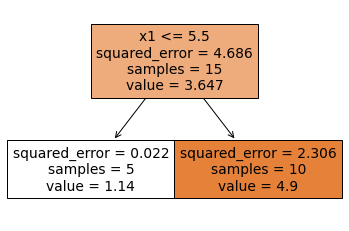

In [28]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)

dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

**Примечание**. Обратите внимание, что значение squared_error в визуализации графа в sklearn считается отдельно для каждой вершины до произведения разделения. Например, в корневой вершине squared_error=4.686 — значение квадрата ошибки до произведения разделения. Точно такое же значение (с точностью до сотых) у нас получалось при ручном подсчёте.

### Задание 4.3

Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений:

In [29]:
ames_data = pd.read_csv('data/AmesHousing.zip')

ames_data = ames_data[(ames_data["Lot Frontage"] <= 150) & (ames_data["Lot Area"] <= 20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)

X = ames_sample[["Lot Frontage", "Lot Area"]]
y = ames_sample["SalePrice"]

Найдите оптимальные для построения решающего пня параметры разбиения $j$ и $t$. В качестве критерия информативности используйте квадратичную ошибку.

Если вы хотите попрактиковаться в использовании формул, можно проделать операцию построения дерева решений вручную.

**Примечание**. Для самопроверки обучите на данной части датасета дерево решений из sklearn с максимальной глубиной 1, критерием информативности 'squared_error' и параметром random_state = 0 и визуализируйте его граф.

1. На основе какого фактора  будет построено решающее правило в корневой вершине?

In [30]:
optimal_split_params = best_split(X, y, criterion=squared_error)
X.columns[optimal_split_params[0]]

'Lot Frontage'

2. Чему равно оптимальное пороговое значение ? Ответ приведите в виде целого числа.

In [31]:
optimal_split_params[1]

71.0

3. Чему равно значение взвешенной неоднородности после разбиения при найденных оптимальных параметрах сплита? Ответ округлите до целого числа.

In [32]:
round(calculate_weighted_impurity(X, y, optimal_split_params, squared_error))

1414654917

## КРИТЕРИИ ИНФОРМАТИВНОСТИ В ЗАДАЧЕ КЛАССИФИКАЦИИ

Все критерии для задачи классификации, которые мы будем рассматривать, основаны на вероятности принадлежности к классу. Пусть у нас есть $K$ классов. Тогда оценка вероятности принадлежности к классу под номером $k$ определяется как:

$$P_k=\frac{1}{N}\sum_{y \in \ Q}{}[y=k]$$

### 1. ЭНТРОПИЯ ШЕННОНА (ENTROPY)

Первый критерий, который мы рассмотрим, — это энтропия Шеннона. Она измеряет непредсказуемость реализации случайной величины.

$$H(Q)=-\sum^K_{k=1}{}P_klog(P_k)$$

Основание логарифма $log$ на самом деле не имеет значения, но традиционно используется логарифм по основанию $2$($log_2$).

Данную метрику Шеннон вывел, занимаясь вопросами кодирования строк. Однако затем выяснилось, что полученная формула очень хорошо подходит теории случайных величин. Энтропия численно отражает меру хаоса и активно используется во многих прикладных задачах — от шифрования до машинного обучения.

***Примечание для любознательных***

Возможно у вас возник вопрос: когда энтропия минимальна и максимальна?

Найти **минимум** довольно просто. Энтропия неотрицательна, так как все слагаемые неотрицательны — это вероятности, а они не могут быть меньше 0. Значит, минимум энтропии лежит в нуле:

$$-\sum^K_{k=1}{}P_klog(P_k)=-(P_1log(P_1)+P_2log(P_2)+...+P_Klog(P_K))=0$$

Минимум энтропии (нулевая энтропия) достигается, когда одна из вероятностей $P_k$ равна $1$, а остальные равны $0$. Например, если в вашем датасете все наблюдения относятся к одному классу, энтропия будет равна 0, а неопределённость будет отсутствовать.

С **максимумом** чуть сложнее. Чтобы его найти, необходимо ввести условие нормировки вероятностей — сумма вероятностей всегда равна $\sum^K_{k=1}{}P_k=1$.

Далее вводим задачу поиска условного экстремума:

$$-\sum^K_{k=1}{}P_klog(P_k)\to max$$

$$\sum^K_{k=1}{}P_k=1$$

Как вы помните, мы решаем задачи оптимизации с ограничениями с помощью метода Лагранжа. Составляется функция Лагранжа:

$$-\sum_k{}P_klog(P_k)+\lambda \sum^K_{k=1}{}P_k\to max$$

Найдя частную производную по всем переменным $P_k$ и приравняв их к 0, мы получим систему уравнений. Решив её, мы сможем найти условие максимума и сам максимум.

Максимум энтропии равен $1$. Он достигается, когда все вероятности равны друг другу, то есть $P_1=P_2=...=P_K=\frac{1}{K}$. Это случай равномерного распределения классов. Примером может служить случай, когда в вашем датасете классы идеально сбалансированы.

### 2. КРИТЕРИЙ ДЖИНИ (GINI)

Другой способ вычислить неоднородность в случае задачи классификации — воспользоваться критерием информативности Джини:

$$H(Q)=\sum^K_{k=1}{}P_k(1-P_k)$$

***Примечание для любознательных***

Предположим, мы хотим угадать, кто изображён на картинке: кошка (класс 1), панда (класс 2) или крокодил (класс 3).

Не глядя на картинку, предполагаем, что на ней кошка. У нас есть только два исхода (угадаем/не угадаем). Эти исходы назовём случайной величиной $Z$.

Мы уже знаем, что случайная величина $Z$ с двумя исходами $Z=1$ (успех) и $Z=0$ (неудача) подчиняется распределению Бернулли.

Вероятность нашего успеха — это вероятность того, что на картинке кошка, $P(класс=кошка)=P_1$. Вспоминаем, чему равна дисперсия случайной величины, распределённой по закону Бернулли

$$D(Z)=P_1(1-P_1)$$

Если мы проделаем ту же операцию для всех классов, а затем сложим результирующие дисперсии, получим критерий Джини

$$\sum^K_{k=1}{}D(Z_k)=\sum^K_{k=1}{}P_k(1-P_k)$$

Мы хотим всегда верно угадывать класс объекта — значит, эту дисперсию надо свести к минимуму (нулю)

$$\sum^K_{k=1}{}P_k(1-P_k)=0$$

**Минимум** будет только в том случае, если одна из вероятностей равна $1$, а остальные равны $0$, то есть в нашем датасете должны быть или только кошки, или только панды, или только крокодилы. Тогда случайное угадывание сработает наверняка.

А что насчёт **максимума**? Тут нам нужно будет снова ввести условие нормировки

$$\sum^K_{k=1}{}P_k(1-P_k)\to max$$

$$\sum^K_{k=1}{}P_k=1$$

Далее необходимо будет составить функцию Лагранжа, найти частные производные, приравнять их к 0, решить систему уравнений и получить тот же результат, что и при энтропии.

$$\sum^K_{k=1}{}P_k(1-P_k)+\lambda \sum^K_{k=1}{}P_k\to max$$

Получим, что максимум критерия Джини ($\frac{1}{2}$) достигается, когда выборка сбалансированная, то есть в ней одинаковое количество объектов каждого из классов.

Теперь давайте на **примере** энтропии рассмотрим, как работают введённые нами критерии информативности для задачи классификации ↓

? Пусть у нас есть некоторый датасет, состоящий из 50 наблюдений ($N=50$) и двух факторов, $x_1$ и $x_2$ ($M=2$). Целевая переменная $y$ имеет $K=2$ возможных уникальных значения: $0$ и $1$. Выборка полностью сбалансирована, то есть в ней присутствует по 25 объектов каждого из классов.

![](https://lms.skillfactory.ru/assets/courseware/v1/75cb21fa305c42d22b6674268fe4b036/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_4_9.png)

Предположим, что у нас есть три кандидата в предикаты корневой вершины дерева $B(j,t)$:

$$w=(j,\ t)$$

$$w^{(1)}=(1,\ 3)\ :\ B(j,\ t)=[x_1\le 3]$$

$$w^{(2)}=(1,\ 0)\ :\ B(j,\ t)=[x_1\le 0]$$

$$w^{(3)}=(2,\ 5.5)\ :\ B(j,\ t)=[x_1\le 5.5]$$

Ниже представлена визуализация этих трёх предикатов. В подписях над графиками указано, каким станет соотношение классов в каждой из полученных областей (класс 0 обозначен **чёрным** цветом, класс 1 — **жёлтым**):

![](https://lms.skillfactory.ru/assets/courseware/v1/99dc98c2fd226c90b5ea65f56def6393/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_4_10.png)

Необходимо понять, какой из предикатов лучше всего подходит для размещения в корневой вершине дерева.

**Примечание**. Без всякой математики видно, что наилучшим является разделение по предикату $[x_1 \le 0]$ — оно обеспечивает практически идеальное разделение на классы.

Однако это очевидно лишь для того, кто смотрит на график. Давайте проследим, как к этому же утверждению придёт дерево решений.

В начальный момент времени в датасете есть по 25 точек каждого из классов.

Энтропия начального состояния равна:

$$P_k=\frac{1}{N}\sum_{y\in \ Q}{}[y=k]$$

$$P_0=P_1=\frac{25}{50}$$

$$H(Q)=-\sum_k{}P_klog_2(P_k)=-(\frac{25}{50}log_2(\frac{25}{50})+\frac{25}{50}log_2(\frac{25}{50}))=1$$

1. При выборе в качестве параметров разбиения $w^{(1)}=(1, \ 3)$ мы получаем предикат $B(j,\ t)=[x_1 \le 3]$, который разбивает множество объектов и ответов к ним ($Q$) на две части — $Q^{left}$ и $Q^{right}$. В левую часть попадает $N^{left}=37$ точек (из них 25 чёрных и 12 жёлтых), а в правую — $N^{right}=13$ точек (все из них являются жёлтыми). 

    Энтропия левой части:

    $$H(Q^{left})=-\sum_k{}P^{left}_klog_2(P^{left}_k)-(\frac{25}{37}log_2(\frac{25}{37})+\frac{12}{37}log_2(\frac{12}{37}))\approx 0.9$$

    Энтропия правой части:

    $$H(Q^{right})=-\sum_k{}P^{right}_klog_2(P^{right}_k)=-(\frac{0}{13}log(\frac{0}{0})+\frac{13}{13}log(\frac{13}{13}))=0-1log_21\approx 0$$

    Взвешенная неоднородность при $w=(1,\ 3)$:

    $$G(Q,\ w)=\frac{N^{left}}{N}H(Q^{left})+\frac{N^{right}}{N}H(Q^{right})=\frac{37}{50}\cdot 0.9+\frac{13}{50}\cdot 0=0.67$$

2. При выборе в качестве параметров разбиения $w^{(3)}=(1, \ 0)$ мы получаем предикат $B(j,\ t)=[x_1 \le 0]$, который разбивает множество объектов и ответов к ним ($Q) на две части — $Q^{left}$ и $Q^{right}$. В левую часть попадает $N^{left}=23$ точки (из них 7 чёрных и 16 жёлтых), а в правую — $N^{right}=27$ точек (из них 18 чёрных и 9 жёлтых).

    Считаем чему равна неоднородность такого состояния.

    Энтропия левой части:

    $$H(Q^{left})=-(\frac{7}{23}log_2(\frac{7}{23})+\frac{16}{23}log_2(\frac{16}{23}))\approx 0.88$$

    Энтропия правой части:

    $$H(Q^{right})=-(\frac{18}{27}log(\frac{18}{27})+\frac{9}{27}log(\frac{9}{27}))\approx 0.91$$

    Итоговая неоднородность при $w=(1,\ 0)$:

    $$G(Q,\ w)=\frac{N^{left}}{N}H(Q^{left})+\frac{N^{right}}{N}H(Q^{right})=\frac{23}{50}\cdot 0.88+\frac{27}{50}\cdot 0.91=0.89$$



3. При выборе в качестве параметров разбиения $w^{(2)}=(2, \ 5.5)$ мы получаем предикат $B(j,\ t)=[x_2 \le 5.5]$, который разбивает множество объектов и ответов к ним ($Q$) на две части — $Q^{left}$ и $Q^{right}$. В левую часть попадает $N^{left}=23$ точки (из них 22 чёрных и 1 жёлтая), а в правую — $N^{right}=27$ точек (из них 3 чёрных и 24 жёлтых).

    Считаем, чему равна неоднородность такого состояния.

    Энтропия левой части:

    $$H(Q^{left})=-\sum_k{}P^{left}_klog_2(P^{left}_k)=-(\frac{22}{23}log_2(\frac{22}{23})+\frac{1}{23}log_2(\frac{1}{23}))\approx 0.25$$

    Энтропия правой части:

    $$H(Q^{right})=-\sum_k{}P^{right}_klog_2(P^{right}_k)=-(\frac{3}{27}log(\frac{3}{27})+\frac{24}{27}log(\frac{24}{27}))\approx 0.5$$

    Итоговая неоднородность при $w=(2,\ 5.5)$:

    $$G(Q,\ w)=\frac{n^{left}}{n}H(Q^{left})+\frac{n^{right}}{n}H(Q^{right})=\frac{23}{50}\cdot 0.25+\frac{27}{50}\cdot 0.5=0.39$$



Теперь осталось только выбрать такие параметры предиката $w$, при которых $G(Q, w)$ минимальна:

$w_{opt}=(j_{opt},\ t_{opt})=argmin_w\ G(Q,w)=argmin_w([0.67,\ 0.39,\ 0.89])=(1,\ 0)$

Таким образом, оптимальным для размещения в корневой вершине является предикат $B(x_j,\ t)=[x_1\le 0]$, что вполне ожидаемо. 

Прирост информации в таком случае будет равен:

$IG(Q,\ w_{opt})=H(Q)-G(Q,\ w_{opt})=1-0.39=0.71$

? А что насчёт кода? Как изменится код для поиска оптимальных параметров разбиения для задачи классификации?

Сам алгоритм не изменится — просто вместо расчёта квадратичной ошибки мы будем рассчитывать критерий информативности для классификации, например энтропию.

Реализуем функцию entropy(), которая рассчитывает энтропию Шеннона. На вход функции приходит целевая переменная $y$. Далее с помощью функции value_counts() считаются доли каждого из классов — вероятности принадлежности к классам. Затем эти вероятности логарифмируются по основанию $2$, и наконец по приведённой выше формуле рассчитывается энтропия.

In [33]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

Для вызова самой функции best_split() нужно будет только поменять критерий информативности (параметр criterion). Пример:

In [34]:
optimal_params = best_split(X, y, criterion=entropy)


### Задание 4.5

Дана часть датасета о банкнотах, состоящая из 15 наблюдений:

In [35]:
bill_data = pd.read_csv('data/bill_authentication.zip')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

Найдите оптимальные для построения решающего пня параметры разбиения  и . Для этого воспользуйтесь функцией best_split(), которую мы реализовали ранее. В качестве критерия информативности используется энтропию Шеннона.

Если вы хотите попрактиковаться в использовании формул, можно проделать операцию построения дерева решений вручную.

Примечание. Для самопроверки обучите на данной части датасета дерево решений из sklearn с максимальной глубиной 1, критерием информативности 'entropy' и параметром random_state = 0 и визуализируйте его граф.

1. На основе какого фактора $x_j$ будет построено решающее правило в корневой вершине?

In [36]:
optimal_params = best_split(X, y, criterion=entropy)

X.columns[optimal_params[0]]

'Skewness'

2. Чему равно оптимальное пороговое значение $t$? Ответ округлите до трёх знаков после точки-разделителя.

In [37]:
optimal_params[1].round(3)

3.221

3. Чему равно значение взвешенной неоднородности после разбиения при найденных оптимальных параметрах сплита? Ответ округлите до двух знаков после точки-разделителя.

In [38]:
round(calculate_weighted_impurity(X, y, optimal_params, entropy), 2)

0.46

## *ПАРАЛЛЕЛЬНЫЕ ВЫЧИСЛЕНИЯ НЕОДНОРОДНОСТИ

Вероятно, вы заметили, что вычисление оптимальных параметров разбиения внутри вершины дерева — очень утомительная операция со множеством громоздких формул и вычислений.

Мы рассмотрели два «игрушечных» примера построения корневой вершины дерева для задач регрессии и классификации. При этом мы брали всего по три возможных кандидата в предикаты. В реальности данных и кандидатов в параметры разбиения значительно больше. Представьте, сколько вычислений производит компьютер при построении, казалось бы, простой модели дерева решений.

Внимательный студент заметил, что взвешенную неоднородность $G(Q, w)$ для каждого случая параметров $w$ мы считали отдельно, то есть независимо, а уже затем из полученных результатов выбирали минимум.

⭐ Идея! Раз все вычисления производятся на компьютере, можно использовать **параллельные вычисления на многоядерном процессоре** и считать неоднородность $G(Q, w)$ для каждой комбинации $w$ параллельно с другими, тем самым значительно повышая скорость построения дерева решений. Эта идея активно используется во многих библиотечных реализациях алгоритма CART, включая sklearn.

# 5. Алгоритм CART: рекурсия, критерии остановки

⭐ **Поздравляем** — вы научились строить решающие пни как для задачи регрессии, так и для задачи классификации. От финального алгоритма построения дерева решений по методу CART нас отделяет последний шаг. Нам осталось ответить на один вопрос: как обобщить полученный алгоритм построения решающего пня для деревьев произвольной глубины?

**Небольшое, но важное лирическое отступление**. Легко убедиться, что для любой выборки можно построить решающее дерево, не допускающее на ней ни одной ошибки. Даже с простыми предикатами $[x_j\le t]$ можно сформировать дерево, в каждом листе которого находится ровно по одному объекту выборки. По своему практическому опыту мы уже знаем, что, скорее всего, это дерево будет переобученным из-за слишком большого количества листьев, и выглядеть оно будет примерно так:

![](https://lms.skillfactory.ru/assets/courseware/v1/03b02fb4b873531698865bc5d834782f/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_5_1.png)

Очевидно, что настолько громоздкие деревья нам не подойдут.

Тогда можно было бы поставить задачу поиска дерева, которое является минимальным (с точки зрения количества листьев) среди всех деревьев, не допускающих ошибок на обучении — в этом случае можно было бы надеяться на наличие у дерева обобщающей способности. К сожалению, было доказано, что эта задача является слишком сложной (если быть точнее, [NP-полной](https://ru.wikipedia.org/wiki/NP-%D0%BF%D0%BE%D0%BB%D0%BD%D0%B0%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0)), а время построения дерева неприемлемо велико.

Как тогда быть? Придётся отказаться от идеи поиска оптимальной структуры дерева. Будем искать не всю структуру дерева целиком, а строить его уровень за уровнем, последовательно.

Схематично **поэтапное построение дерева решений** выглядит следующим образом:

![](https://lms.skillfactory.ru/assets/courseware/v1/b094f3baa537f2183b4f2bb03b1c3b67/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_5_2.png)

Допустим, мы построили решающий пень. В результате построения получилась одна родительская и две дочерние вершины, каждой из которых соответствует своя часть исходной выборки.

![](https://lms.skillfactory.ru/assets/courseware/v1/e0be7e28d4c0816b0665a3dd3a422dc3/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_5_3.png)

Чтобы построить следующий уровень дерева, необходимо проделать ту же процедуру построения решающего пня, но теперь уже каждая из дочерних вершин воспринимается как родительская, и её основе строится новый решающий пень. В результате получится дерево глубиной 2.

![](https://lms.skillfactory.ru/assets/courseware/v1/ff2533701fd479d0fbe52749497329d9/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_5_4.png)

Строим следующий уровень: дочерние вершины снова воспринимаем как родительские и на их основе строим новые решающие пни. Получаем дерево глубиной 3.

Повторяем эти действия, пока не дойдём до некоторого предела, на котором нужно будет остановиться: например, если мы достигли идеальной однородности (все объекты относятся к одному классу).

**Примечание**. Формально такой последовательный алгоритм построения дерева относится к категории [жадных](https://ru.wikipedia.org/wiki/%D0%96%D0%B0%D0%B4%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC) алгоритмов. 

Внимательные студенты уже догадались, что описанная нами процедура построения дерева является **рекурсией**. Мы рекурсивно используем алгоритм построения решающего пня для каждой из дочерних вершин, тем самым создавая всё новые и новые вершины графа.

**Примечание**. Если вы забыли, как мыслить рекурсивно, то можете вновь настроить себя на нужный лад, обратившись к модулю [PYTHON-5.2. «Продвинутое использование функций в Python»](https://lms.skillfactory.ru/courses/course-v1:SkillFactory+DST-3.0+28FEB2021/jump_to_id/dd98e1dc834a4519a89dc77a5647d815) и повторив тему рекурсии.

Теперь давайте переведём наши рассуждения на язык математики и сформулируем итоговый алгоритм построения дерева.

**Примечание**. Отметим, что, так как мы теперь рассматриваем не решающие пни, а деревья произвольной глубины, то в наших рассуждениях появится **индекс вершины дерева** $v$. Он вводится для того, чтобы обозначить, что та или иная величина рассчитывается для конкретной вершины.

Итак, пусть $Q_v=\{(x,\ y)$ — множество объектов и ответов к ним, попавших в вершину с номером $v$, $N_v = \left|Q_v \right|$. Пусть задан критерий информативности $H(Q)$, который зависит от задачи (регрессия — Squared Error, Absolute Error или Poisson Error, классификация — Gini или Entropy). Также задан некоторый критерий остановки рекурсии $stop\_criterion(Q_v)$. О том, какими могут быть критерии остановки, мы поговорим чуть позже.

Наш **алгоритм построения дерева решений CART** будет выглядеть следующим образом:

1. Создаём вершину под номером $v$. 

2. По умолчанию ветвление дерева решений прекращается, когда достигается однородность, то есть $H(Q_v)=0$. 

    **2.1. Если условие остановки выполнено.**

    Формируем листовую вершину $v$ и ставим в соответствие этому листу ответ, который будет выдаваться для новых объектов, которые дойдут до этого листа. Назовём эту часть create_leaf().

    * В случае задачи регрессии ответ вычисляется как среднее (если критерий информативности $H(Q)$ — Squared Error или Poisson Error) или медиана (если критерий информативности — Absolute Error):

        $${\hat{y}}_v=\frac{1}{N_v}\sum_{y\ \in \ Q_v}{}y$$        

        $$или$$

        $${\hat{y}}_v=median_{y\ \in \ Q_v}(y)$$

    * В случае задачи классификации ответ вычисляется как метка самого популярного среди объектов $X_v$ класса или как оценки вероятностей принадлежности $P_{vk}$ к каждому из классов:

    $$P_{vk}=\frac{1}{N_v}\sum_{y\ \in \ Y_v}{}[y=k],$$


    $${\hat{y}}_v=argmax_{k\in K}(P_{vk})$$

    **2.2. Если условие остановки не выполнено.**

    Строим решающий пень. Формируем решающее правило $B_{v}(x_j,\ t)$ для вершины $v$. Из возможных комбинаций $w=(j,\ t)$ выбираем такую, которая определяет наилучшее разбиение текущего множества объектов и ответов к ним $w=(j,\ t)$ на две части: $Q^{left}=\{(x,\ y) \mid \ x_j \le t\}$ — левую, для которой условие предиката истинно, и $Q^{right}_v=\{(x,\ y) \mid \ x_j >t\}$ — правую, для которой условие предиката ложно:

    $$G(Q,\ w)=\frac{N^{left}_v}{N_v}H(Q^{left}_v)+\frac{N^{right}_v}{N_v}H(Q^{right}_v)$$

    $$w_{opt}=(j_{opt},\ t_{opt})=argmin_w\ G(Q,\ w)$$

    $$B_{\nu }(x_j,\ t)=[x_{j_{opt}}\le t_{opt}]$$

    Эту часть алгоритма мы обозначали ранее как best_split().

    В результате разбиения будут созданы два подмножества объектов — $Q^{left}_v$ и $Q^{right}_v$. На основе этих подмножеств мы с помощью рекурсии создадим две новые вершины дерева (левую и правую)$Q^{left}_v$ и $Q^{right}_v$ свяжем их с текущей вершиной.

    Для выборок  и  процедура будет повторяться рекурсивно, пока не выполнится критерий остановки.

3. Возвращаем созданную вершину.

Теперь у нас есть всё, чтобы реализовать собственное дерево решений. Настало время воплотить наш алгоритм в виде кода ↓

[→ Скачать ноутбук из скринкаста](https://lms.skillfactory.ru/assets/courseware/v1/951ea3f2989659b02fe92ef8c07f4ba8/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/DecisionTree_CART.ipynb) (этот ноутбук использовался в скринкастах предыдущих юнитов — если вы скачали его ранее, скачивать заново не нужно)

Для начала создадим вспомогательный класс вершины. У него будут следующие атрибуты:

* left — ссылка на левого потомка;
* right — ссылка на правого потомка;
* value — ответ алгоритма;
* split_params — параметры разбиения (сплита);
* impurity — неоднородность в вершине (пригодится для расчёта важности признаков);
* samples — количество объектов, попавших в вершину;
* is_leaf — булева переменная, которая указывает, является ли вершина корневой.

По умолчанию все параметры заданы как None.

In [39]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

* Если вершина является корневой или внутренней, для неё устанавливаются ссылки на потомков, параметры разбиения, неоднородность и количество объектов.

* Если вершина является листовой, для неё указываются только ответ, неоднородность и количество объектов, а параметр is_leaf устанавливается в значение True.

Для случая задачи классификации ответ — это класс с наибольшей вероятностью, иначе говоря, самый популярный класс. Мы знаем, что самое популярное значение — это мода, а в Pandas как раз есть функция, которая позволяет вычислять её в одну строку кода, — mode(). Помним, что мод может быть несколько — нам нужна любая из них, поэтому мы берём первое значение из списка.

Реализуем эту часть в виде функции create_leaf_prediction(). Она будет принимать на вход целевую переменную y и возвращать модальное значение:


In [40]:
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

Далее введём критерий остановки. Самый базовый критерий — равенство нулю критерия информативности, рассчитанного по вершине.

In [41]:
def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

Наконец, создадим функцию build_decision_tree(). Она будет реализовывать сам рекурсивный алгоритм построения дерева решений. Функция будет принимать на вход выборку X и y, а также критерий информативности. На выходе функции должна быть корневая вершина дерева (объект класса Node). Она будет ссылаться на своих левого и правого потомка, они в свою очередь будут ссылаться на своих потоков, и так далее до самых листьев.

In [42]:
def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    
    return node

Также напишем вспомогательную функцию print_decision_tree(). Она будет принимать на вход корневую вершину дерева решений и рекурсивно выводить дерево решений в виде текста:

In [43]:
def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)

Давайте обучим наше дерево решений на игрушечном датасете о выдаче кредитов клиентам банка и напечатаем его. Напомним, что у нас есть два фактора:  — возраст заёмщика,  — доход заёмщика. Целевая переменная $y$ — бинарная (0 — кредит погашен, 1 — кредит не погашен).

In [44]:
# Создаём обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             feature_0 <= 19.000:
                class: 1
             feature_0 > 19.000:
                class: 0
          feature_0 > 22.500:
             class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


Давайте сравним наш результат с деревом решений из sklearn, напечатав его в текстовом виде с помощью функции export_text() из модуля tree. Не будем ограничивать глубину дерева, а в качестве значения параметра random_state возьмём 1000 для совпадения результатов:

In [45]:
# Создаём модель дерева решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Выводим дерево решений на экран в виде списка условий
print(tree.export_text(decision_tree=dt))

|--- feature_0 <= 43.50
|   |--- feature_1 <= 86.00
|   |   |--- feature_0 <= 22.50
|   |   |   |--- feature_0 <= 19.00
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  19.00
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  22.50
|   |   |   |--- class: 1
|   |--- feature_1 >  86.00
|   |   |--- class: 0
|--- feature_0 >  43.50
|   |--- class: 0



Мы своими руками реализовали алгоритм построения деревьев решений CART и получили такое же дерево, как в sklearn (исключая линии разметки).

Как вы понимаете, построить дерево решений мало — нужно ещё научить его предсказывать целевую переменную для новых объектов. Для этого реализуем две функции:

* predict_sample() принимает на вход вершину и один объект из выборки x. Алгоритм предсказания следующий: нужно рекурсивно передвигаться по дереву на основе характеристик объекта (если $x[j] \leq t$ — в левую вершину, иначе — в правую), а когда дойдём до листовой вершины, вернуть предсказание, которое присвоено этому листу (value).

In [46]:
def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

* predict() принимает на вход дерево решений и матрицу из объектов X, для которых нужно сделать предсказание. Внутри себя функция должна сделать предсказание для всех объектов из X — вызвать функцию predict_sample(). Результат оборачивается в список, а затем в numpy-вектор.

In [47]:
def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

Проверим наши функции. Сделаем предсказание выплаты/невыплаты заёмщиком кредита для всех объектов из обучающей выборки:

In [48]:
# Предсказываем целевую переменную
y_pred = predict(decision_tree, X)
print('Predictions: {}'.format(y_pred))
# Predictions: [1 0 1 0 1 0 0 1 1 0]

Predictions: [1 0 1 0 1 0 0 1 1 0]


Примечание. Конечно, алгоритм CART в sklearn реализован намного сложнее и при этом работает в десятки раз быстрее, чем наш вручную созданный алгоритм, поскольку в sklearn:

код построения деревьев реализован на языке программирования C, что значительно повышает производительность;
код оптимизирован разработчиками до мелочей: каждый шаг алгоритма продуман так, чтобы он выполнялся за минимальное время, а процессы, которые можно выполнять одновременно, реализованы параллельно.
Наш же пример является учебным и лишь демонстрирует, как работает введённая нами математика. При выполнении реальных задач рекомендуем вам пользоваться реализацией из sklearn.

**Примечание**. Для задачи регрессии в коде изменится только функция create_leaf_prediction(). Вместо модального значения классов в листьях рассчитывается среднее значение целевой переменной:


```py

def create_leaf_prediction(y):
    value = y.mean()
    return value

### Задание 5.3

Дана часть датасета о банкнотах, состоящая из 15 наблюдений:

In [49]:
bill_data = pd.read_csv('data/bill_authentication.zip')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

Постройте дерево решений на обучающей выборке с помощью функции build_decision_tree(). В качестве критерия информативности используйте энтропию Шеннона.

**Примечание**. Для самопроверки обучите на данной части датасета дерево решений с неограниченной максимальной глубиной и визуализируйте его граф. Чтобы получить тот же результат, установите параметр random_state = 0.

1. Сколько вершин дерева используют в качестве признака разбиения фактор  (Variance)?

In [50]:
build_decision_tree(X, y, entropy)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             feature_0 <= 19.000:
                class: 1
             feature_0 > 19.000:
                class: 0
          feature_0 > 22.500:
             class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


## КРИТЕРИИ ОСТАНОВКИ



> Как мы уже знаем, любая рекурсия всегда должна имеет **критерий остановки** — условие, при котором рекурсивный вызов прекращается.

В нашем случае также должно быть такое условие, а лучше целый набор условий, при которых ветвление дерева прекратится. В нашем алгоритме мы назвали данный шаг $stop\_critetion(Q_v)$.

В реализации дерева решений в sklearn предусмотрено несколько критериев, при выполнении одного из которых ветвление дерева прекращается. Мы рассмотрим основные из них на примере нашего «игрушечного» датасета о выплатах кредита.

In [51]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'y': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
# Создаём обучающую выборку
X = data[['age', 'income']]
y = data['y']

### 1. ДОСТИЖЕНИЕ ОДНОРОДНОСТИ

Этот критерий остановки мы уже использовали при построении своего дерева. Он является основным, то есть действует, если исследователем не установлены другие ограничения.

Критерий гласит: ветвление дерева решений прекращается, когда неоднородность вершины, определяемая критерием информативности? минимальна, то есть $H(Q)=0$.

Для задачи **классификации** это условие означает, что все объекты в вершине являются объектами одного класса.

Для задачи **регрессии** это условие означает, что средняя ошибка предсказания вершины равна нулю.

Для примера построим дерево решений, используя наш «игрушечный» датасет. При этом все параметры оставим по умолчанию. Получим следующее дерево:

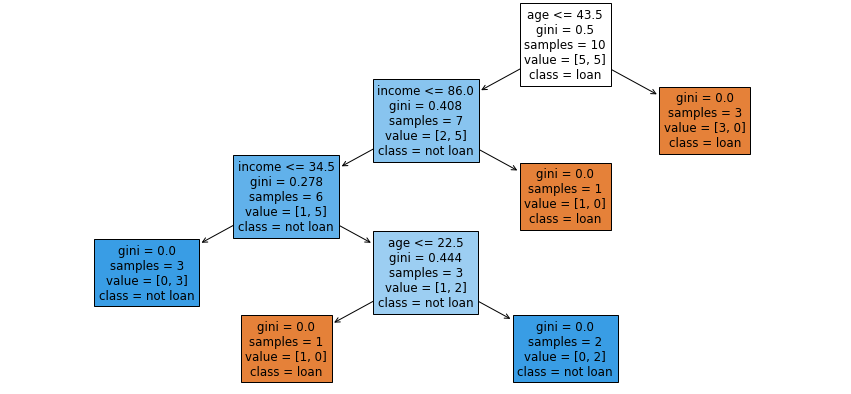

In [52]:
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

Обратите внимание, что во всех листовых вершинах неоднородность, обозначенная как gini, равна 0, а в самих листьях содержатся объекты (value) только одного определённого класса.

### 2. ОГРАНИЧЕНИЕ МАКСИМАЛЬНОЙ ГЛУБИНЫ ДЕРЕВА (ПАРАМЕТР MAX_DEPTH)

Это самый простой критерий. Мы работали с ним уже десятки раз, используя деревья решений для задач классификации и регрессии.

Идея состоит в том, что, когда дерево достигает максимально заданной глубины, ветвление прекращается. С точки зрения программной реализации, это означает ограничение глубины рекурсии.

По умолчанию глубина дерева не ограничена. Помните, что ограничение глубины дерева решений является основным методом борьбы с его переобучением.

В качестве примера ограничим глубину нашего дерева решений до 3:



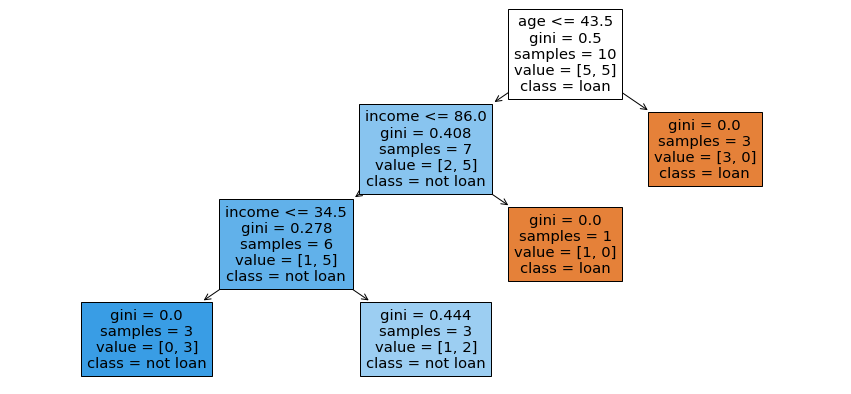

In [53]:
dt = tree.DecisionTreeClassifier(
    max_depth=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

### 3. ОГРАНИЧЕНИЕ МАКСИМАЛЬНОГО КОЛИЧЕСТВА ЛИСТЬЕВ В ДЕРЕВЕ (ПАРАМЕТР MAX_LEAF_NODE)

Здесь всё происходит по аналогии с максимальной глубиной дерева: мы задаём максимальное количество листьев, которое может быть в дереве — когда количество листьев в дереве достигает этой верхней планки, ветвление прекращается.

По умолчанию количество листьев не ограничено. Как и все критерии остановки, ограничение на количество листьев может служить инструментом борьбы с переобучением дерева.

Для примера ограничим количество листьев в нашем дереве до 3:



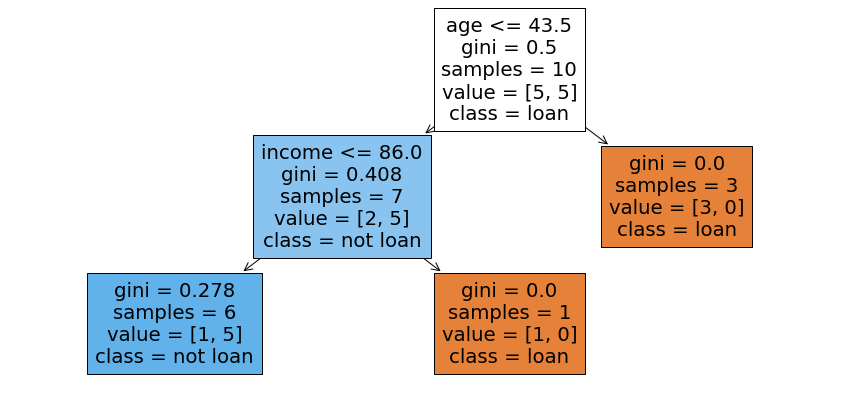

In [54]:
dt = tree.DecisionTreeClassifier(
    max_leaf_nodes=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

Видим, что из-за ограничения на количество листьев в дереве разделения по предикату $[income \le 34.5]$ не произошло — вместо этого данная вершина превратилась в листовую, и итоговая глубина дерева уменьшилось с 4 до 3. Общее количество листьев в дереве, как мы и указывали, равно 3.

### 4. ОГРАНИЧЕНИЕ НА МИНИМАЛЬНОЕ КОЛИЧЕСТВО ОБЪЕКТОВ, ПРИ КОТОРЫХ ДОПУСКАЕТСЯ ВЕТВЛЕНИЕ ДЕРЕВА (ПАРАМЕТР MIN_SAMPLES_SPLIT)

Идея ограничения проста, как и все предыдущие. Пусть в вершину попала выборка $Q_v$, количество объектов в этой вершине — $N_v=5$. При этом однородность в этой вершине не равна .

По идее, ветвление дерева должно быть продолжено. Однако если мы установим ограничение на минимальное количество объектов для разделения (min_samples_split = 6), то разделения вершины не произойдёт.

Для примера обучим дерево решений с параметром min_samples_split = 6:

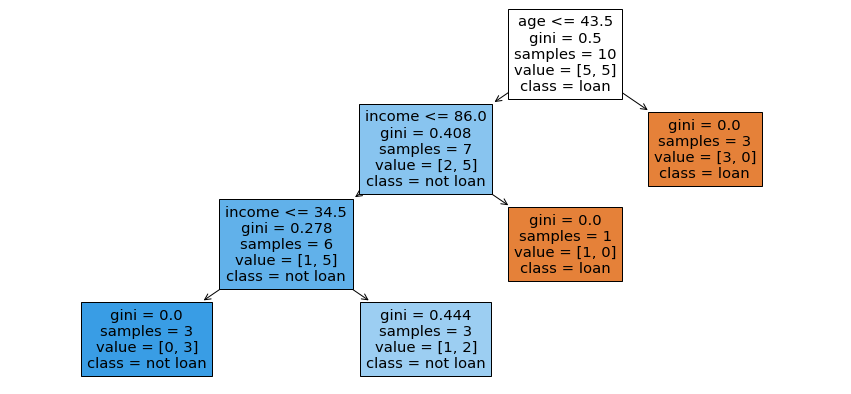

In [55]:
dt = tree.DecisionTreeClassifier(
    min_samples_split=6, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

Видим, что разделение по условию $income \le 34.5$ произошло, так как количество объектов в вершине (samples), соответствующей ему, равно 6. А вот в вершинах, где количество наблюдений равно 3, разделения не произошло.

### 5. ОГРАНИЧЕНИЕ НА МИНИМАЛЬНОЕ КОЛИЧЕСТВО ОБЪЕКТОВ, НЕОБХОДИМЫХ ДЛЯ СОЗДАНИЯ ЛИСТА (ПАРАМЕТР MIN_SAMPLES_LEAF)

Предположим, что при разделении выборки $Q_v$ на $Q^{left}_v$ и $Q^{right}_v$ с параметрами разделения $w$ случилось так, что и в левую вершину попало $N^{left}_v\ =3$ наблюдения, а в правую — $N^{right}_v\ =2$, причём однородность в правой вершине — $G(Q^{right}_v,\ w)=0$. При этом мы поставили ограничение min_samples_leaf=3. 

В таком случае, даже несмотря на равенство нулю однородности в правой вершине, ветвления не произойдёт, так как минимальное количество объектов, которое допускается в листовой вершине, — 3. Это значит, что разделение вершины на две новых при таких параметрах разделения не будет произведено.

Посмотрим на примере, как работает этот критерий. Обучим дерево решений с параметром min_samples_leaf=3:

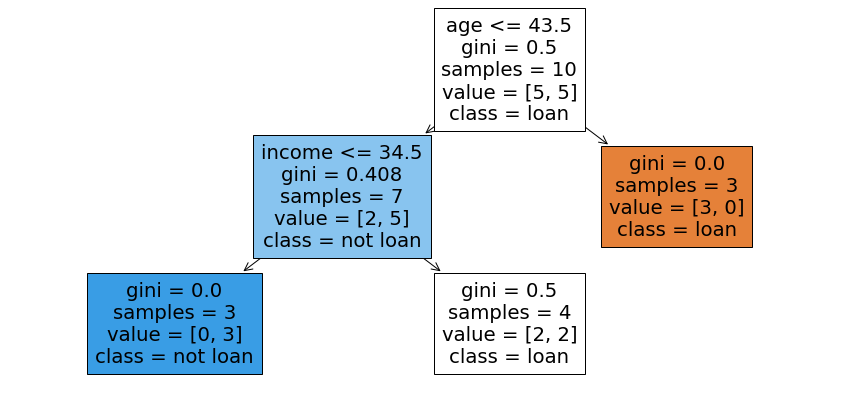

In [56]:
dt = tree.DecisionTreeClassifier(
    min_samples_leaf=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

Обратите внимание, что в одной вершине ранее находилось условие $income \le 86$, а теперь там находится условие $income \le 34.5$. Как это произошло?

На самом деле всё просто. При разделении по решающему правилу $$ у нас бы получались две новых вершины: в левой находилось бы шесть объектов, а в правой — один, причём правая вершина стала бы листовой. Однако у нас стоит ограничение: количество объектов в листовых вершин должно быть не менее 3. Поэтому такое разделение нам не подходит. Под данное условие подходит только одно решающее правило — $[income \le 86]$. При таком разделении в левую вершину попадает три объекта, а в правую — четыре. После этого ветвление прекращается.

Давайте адаптируем наш метод построения дерева решений и введём новое ограничение на максимальную глубину дерева: в функции stop_criterion() и build_decision_tree() добавим параметр max_depth, а также счётчик глубины рекурсии depth:

In [57]:
def stopping_criterion(X, y, criterion, max_depth=None, depth=0):
    if max_depth is None:
        return (criterion(y) == 0) 
    else:
        return (criterion(y) == 0) or (depth > max_depth)
    
def build_decision_tree(X, y, criterion, max_depth=None, depth=0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_rigth, y_right, criterion, max_depth, depth)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

Чтобы проверить результат, построим дерево с максимальной глубиной 2. В качестве данных используем данные о кредитах:

In [58]:
# Строим дерево решений с ограничением глубины и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy, max_depth=2)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


Видим, что глубина дерева уменьшилась до 2 — всё работает.

→ Как вы уже знаете, можно использовать одновременно несколько критериев остановки, тем самым управляя сложностью модели. Например, вы можете одновременно ограничивать и максимальную глубину (max_depth) и количество объектов, необходимых для разделения (min_samples_split). Однако, нельзя заранее сказать, какие внешние параметры дерева решений подойдут вам для решения конкретной задачи, поэтому используются знакомые вам методы подбора гиперпараметров, которые мы обсуждали в модуле [ML-7. «Оптимизация гиперпараметров модели»](https://lms.skillfactory.ru/courses/course-v1:SkillFactory+DST-3.0+28FEB2021/jump_to_id/0ce39a605e9e41b890f69fdf0a17255b).

# 6. Алгоритм CART: значимость признаков

✍ Последняя тема, которую нам осталось обсудить в контексте деревьев решения, — это **значимость признаков (feature importances)**.

Мы знаем, что при построении деревьев рассчитывается так называемая **информативность**, или **важность каждого признака** из обучающего набора данных. Эта величина численно отражает, насколько значимым был фактор $x_j$ для обучения модели, как много информации он даёт.

Как рассчитать эту величину?

На самом деле всё довольно просто, все компоненты этой задачи у нас уже есть.

Для начала вспомним, что такое **прирост информации (information gain)**. Это разница между неоднородностью в вершине $$ до её деления и взвешенной неоднородностью после деления по предикату $B_v(x_j,\ t)=[x_j \le t]$:

$$IG(Q_v,\ w)=H(Q_v)-G(Q_v,\ w)=H(Q_v)-\ \frac{N^{left}_v}{{N_v}}H(Q^{left}_v)-\frac{N^{right}_v}{N_v}H(Q^{right}_v)$$

Иначе говоря, это численное отражение того, сколько информации о целевой переменной нам дал фактор $x_j$ после разделения вершины.

Смысл формулы не изменится, если умножить всё выражение на $N_v$, а вот вид она примет более приятный:

$$IG(Q_v,\ w)={N_v}\cdot H(Q_v)-\ N^{left}_v\cdot H(Q^{left}_v)-N^{right}_v\cdot H(Q^{right}_v)$$

Так как выражение для прироста информации — это не уравнение, то умножать левую часть на $N_v$ необязательно, так как мы просто переходим от одного масштаба к другому.

Значения прироста информации $IG(Q_v, w)$, вычисленные по первой и второй формулам выше, будут различаться ровно в $N_v$ раз, однако при дальнейших вычислениях это не будет иметь значения. Нам не важно, в чём измерять прирост информации (в единицах или сотнях), так как это абстрактная величина.

Итак, $IG(Q_v,\ w)$ — это прирост информации, который даёт признак $x_j$ в вершине с номером $v$. А что, если вершин, которые используют признак $x_j$, будет несколько?

Тогда мы возьмём все эти вершины, посчитаем в них суммарную информативность, а затем разделим сумму на изначальное количество объектов в датасете. В итоге мы получим суммарный прирост информации, получаемый деревом от фактора $x_j$, на один объект из обучающей выборки. Эту величину как раз и назовём **(абсолютной) значимостью признака $x_j$**:

$$F(x_j)=\frac{1}{n}\sum_{v\ \in \ V_j}{}IG(Q_v,\ w)$$

Здесь запись $\sum_{v\ \in \ V_j}$ означает, что мы суммируем прирост информации по тем вершинам, которые содержат признак $x_j$ внутри условия предиката.

В результате по введённой формуле мы можем подсчитать значимость для каждого признака $x_j$ из обучающей выборки — получим целый список из $M$ таких чисел:

$$F(x_1),F(x_2),...,\ F(x_M)\$$

Последний шаг — нормировка. Она производится для того, чтобы сумма всех значимостей была равна $1$. Результатом будет относительная значимость признаков, которая позволяет воспринимать значение значимости каждого из признаков как выраженный в долях вклад фактора $x_j$ в построение дерева решений. 

Чтобы произвести нормировку, необходимо разделить каждое из значений информативности на общую сумму — получим относительные значимости:

$$\overline{F}(x_j)=\frac{F(x_j)}{\sum^M_{j\ =1}{}F(x_j)}$$

**Обратите внимание**, что в данном выражении верхняя черта обозначает нормировку, а не усреднение.

Легко убедиться, что, просуммировав все нормированные значения информативности, мы получим $1$:

$$\sum^M_{j\ =1}{}\bar{F}(x_j)=1$$

Давайте на **примере** посмотрим, как работают эти формулы ↓

Продолжим рассматривать датасет о выплатах кредитов банку. Напомним, что за $x_1$ мы обозначали возраст клиента (age), а за $x_2$ — его доход (income). Пусть мы обучили на данных модель дерева решений и получили следующий граф:

![](https://lms.skillfactory.ru/assets/courseware/v1/db1281b07bd4fd0ea92716b737aef6dd/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_6_1.png)

Давайте рассчитаем относительную значимость каждого из признаков — $\overline{F}(x_1)$ и $\overline{F}(x_2)$.

Сразу условимся, что корневую вершину будем нумеровать как $v=0$, а остальные — в формате $v=ij$, где $i$ — глубина, на которой находится вершина, а $j$ — порядковый номер слева направо, начиная с 1.

Начнём с признака возраста — $x_1$. На графе ниже выделены вершины, в которых содержится данный фактор.

![](https://lms.skillfactory.ru/assets/courseware/v1/ab375a6a531cc2c1f908ae16105ef4d7/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_6_2.png)

Считаем прирост информации для $x_1$ в корневой вершине. Все данные для этого у нас есть. Размеры выборок $N_v$ записаны в поле samples, а значения неоднородности вершины $H(Q_v)$ (в данном дереве используется энтропия) записаны в поле entropy — нам нужно только подставить числа в формулу:

$IG(Q_0,\ w)={N_0}\cdot H(Q_0)-\ N^{left}_0\cdot H(Q^{left}_0)-N^{right}_0\cdot H(Q^{right}_0)=$

$=10\cdot 1-\ 7\cdot 0.863-3\cdot 0=3.958$

Считаем прирост информации в вершине $v=21$:

$IG(Q_{21},\ w)=6\cdot 0.65-\ 3\cdot 0.918-3\cdot 0=1.146$

Считаем прирост информации в вершине $v=31$:

$IG(Q_{31},\ w)=3\cdot 0.918-\ 2\cdot 0-1\cdot 0=2.754$

Считаем абсолютную значимость признака $x_1$ — прирост информации на одно наблюдение:

$F(x_1)=\frac{1}{N}\sum_{v\ \in \ \{v_0,v_{21},\ v_{31}\}\ }{}IG(Q_v,\ w)=\frac{1}{10}(3.958+1.146+2.754)=0.786$

Переходим к признаку дохода — $x_2$. На графе ниже выделены вершины, в которых содержится данный фактор.

![](https://lms.skillfactory.ru/assets/courseware/v1/b7d42c0e05381d3a1a9a88438f76d1e2/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_6_3.png)

Считаем прирост информации для $x_2$ в вершине $v=11$:

$IG(Q_{11},\ w)=7\cdot 0.863-\ 6\cdot 0.65-1\cdot 0=2.142$

Считаем абсолютную значимость признака $x_2$ — прирост информации на одно наблюдение:

$F(x_2)=\frac{1}{N}\sum_{v\ \in \ \{v_{11}\}\ }{}IG(Q_v,\ w)=\frac{1}{10}\cdot 2.141=0.214$

Финальный шаг — нормировка. Вычислим относительные значимости признаков $x_1$ и $x_2$ и разделим абсолютные значимости на их сумму:

$\overline{F}(x_1)=\frac{F(x_1)}{\sum^2_{j\ =1}{}F(x_j)}=\frac{0.786}{0.786+0.214}=0.786$

$\overline{F}(x_2)=\frac{F(x_1)}{\sum^2_{j\ =1}{}F(x_j)}=\frac{0.214}{0.786+0.214}=0.214$



Обратите внимание, что для случая двух факторов абсолютная и относительные значимости будут всегда совпадать.

Интерпретировать полученные результаты можно следующим образом: доля информации, которую принёс признак возраста клиента $x_1$ при построении дерева решений для целевой переменной $y$ (класса объекта — факта выплаты кредита заёмщиком), составляет $0.786$, или $78.6%$. Признак заработка $x_2$ дал дереву $21.4%$ информации о целевой переменной.

**Примечание**. Здесь нужно сделать важное замечание. Обратите внимание, что полученные результаты относятся к конкретному дереву решений, представленному на графе выше. Полученный результат вовсе не означает, что возраст клиента важнее его заработка при принятии решения о выдаче кредита в глобальном смысле. Принимая какую-то гипотезу и делая категоричные выводы на подобных маленьких выборках с использованием только одного дерева решений, вы рискуете допустить серьёзную исследовательскую ошибку.

Более корректные результаты можно получить на выборках больших размеров с использованием не одного дерева решений, а целых ансамблей из деревьев (случайный лес или градиентный бустинг, о которых мы поговорим в следующем модуле).

И, наконец, традиционный финальный этап — перевод математики в код ↓

[→ Скачать ноутбук из скринкаста](https://lms.skillfactory.ru/assets/courseware/v1/951ea3f2989659b02fe92ef8c07f4ba8/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/DecisionTree_CART.ipynb) (этот ноутбук использовался в скринкастах предыдущих юнитов — если вы скачали его ранее, скачивать заново не нужно)

Реализуем функцию calculate_feature_importances() для расчёта относительных значимостей признаков. Она будет принимать на вход обученное дерево решений. Также у неё будет аргумент по умолчанию — массив из значимостей feature_importances. Так как функция будет рекурсивной, то при первом запуске массив нужно проинициализировать нулями.

Далее, до тех пор пока не «упрёмся» в листья, будем считать прирост информации для признака, записанного в вершине, и заносить результат в массив, затем рекурсивно проделывать то же самое для потомков. После окончания рекурсии образуется массив feature_importances, в котором будут лежать суммарные приросты информации по каждому из признаков. Чтобы получить относительную значимость признаков, нужно будет разделить массив на число наблюдений, а затем нормировать на сумму.

In [59]:
def calculate_feature_importances(node, feature_importance=None):
    if feature_importance is None:
        feature_importance = np.zeros(X.shape[1])
    if node.value is None:
        j = node.split_params[0]
        feature_importance[j] += node.impurity * node.samples - \
                                 node.left.impurity * node.left.samples - \
                                 node.right.impurity * node.right.samples
        calculate_feature_importances(node.left, feature_importance)
        calculate_feature_importances(node.right, feature_importance)
    feature_importance /= node.samples
    feature_importance /= feature_importance.sum()
    return feature_importance

Протестируем функцию на нашем «игрушечном» датасете о кредитах:



In [60]:
# Создаём обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, entropy)
# Вычисляем значения информативности признаков
print(calculate_feature_importances(decision_tree))
# [0.78582905 0.21417095]

[0.78582905 0.21417095]


Итак, мы получили тот же результат, что и при ручном расчёте.

Ещё один способ проверить себя — свериться с результатами библиотеки sklearn:

In [61]:
# Создаём модель дерева решений и обучаем её
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Вычисляем значения информативности признаков
print(dt.feature_importances_)
# [0.78582905 0.21417095]

[0.78582905 0.21417095]


Примечание. Если факторов, участвующих в построении дерева, много, то удобнее всего отсортировать их по коэффициенту значимости и визуализировать, например, в виде столбчатой диаграммы значимости. Пример:

![](https://lms.skillfactory.ru/assets/courseware/v1/0ebaf799a53deadf66c82374fc5629ec/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_6_4.png)

#  7. Деревья решений: практика

✍ Давайте закрепим навыки работы с деревьями, решив реальную задачу из практического кейса.

Начнём немного издалека. Представьте, что вы общаетесь с незнакомым человеком по телефону или сидя к нему спиной. Сможете ли вы по нескольким фразам понять, какого пола ваш собеседник? В большинстве случаев это будет лёгкой задачей. Но задумывались ли вы, как ваш мозг определяет пол человека по голосу?

![](https://lms.skillfactory.ru/assets/courseware/v1/e1aee0e91b60fb078be1a941816d09ad/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/MATHML_md8_7_1.png)

Всё очень просто: женские и мужские голоса заметно различаются по акустическим свойствам. Есть существенные физиологические различия, подтверждённые научно и активно используемые как в общественной жизни, так и технических устройствах. Они обусловлены небольшими различиями в строении речевого аппарата мужчины и женщины, которые формируются с возрастом. Эти различия проявляются в частотах звука, тембре и громкости.

Поэтому когда вы слышите незнакомый голос, ваш мозг на основе его акустических свойств и уже заранее заготовленных паттернов в вашей памяти определяет пол человека.

Почему бы нам не обучить модель машинного обучения классифицировать людей на мужчин и женщин по их голосу? Системе идентификации пола по голосу, основанной на такой модели, можно найти применение во многих областях — от маркетинга до интегрирования в системы безопасности.

На Kaggle можно найти множество датасетов для решения этой задачи. Большинство из них состоят из больших массивов размеченных аудиофайлов, обработку которых составители датасетов возлагают на исследователей.

Мы пока что не умеем работать с аудиоинформацией и преобразовывать её в привычный нам формат табличных данных, поэтому для решения данной задачи мы нашли готовый датасет, в котором все преобразования аудиоинформации в числовой табличный формат уже произведены.

Оригинальную страницу датасета на Kaggle с подробным описанием задачи вы можете найти [здесь](https://www.kaggle.com/datasets/primaryobjects/voicegender).

Набор данных состоит из 3 168 записанных образцов голоса мужчин и женщин. Образцы предварительно обрабатываются с помощью акустического анализа на языке программирования R с использованием специальных библиотек в диапазоне частот 0 Гц-280 Гц (диапазон человеческого голоса). Если вкратце, в результате обработки звук на аудиозаписи оцифровывается и преобразуется в числовую последовательность частот, из которой извлекаются различные статистические характеристики, например средняя частота, с которой говорит спикер на аудиозаписи, или частота с наибольшей энергией и так далее.

Файл с данными, представленными в формате CSV, вы можете скачать [здесь](https://lms.skillfactory.ru/assets/courseware/v1/0446d35f217801309147def00a120238/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/voice_gender.zip).

В столбцах таблицы содержатся статические характеристики для каждой из аудиозаписей, вычисленные на основе акустических свойств.

Здесь стоит сделать **важное лирическое отступление**.

Очень часто Data Scientist сталкивается с задачами, которые находятся за гранью области его компетенций. Типичный пример — медицинские задачи. Дата-сайентист может не разбираться в том, как получаются те или иные медицинские показатели, в чём они измеряются и какая у них норма, ведь это зона компетенций врача. Однако это же не повод не решать поставленную задачу (хотя, конечно же, базовое понимание внутренней кухни в большинстве случаев даёт определённый бонус).

Мы сейчас как раз рассматриваем пример подобного рода — нам интересен не столько процесс извлечения данных из каждой аудиозаписи, сколько сам результат.

Наша цель как специалистов в Data Science состоит в построении модели распознавания пола по уже обработанным аудиозаписям, а не в проектировании процесса их обработки. То есть в процессе решения задачи вы вполне можете абстрагироваться от непосредственного значения самих признаков и воспринимать их в математическом ключе как векторы $x_1, \ x_2, \ ..., \ x_M$.

Для любознательных студентов мы привели список столбцов и их краткое описание.

* meanfreq — средняя частота голоса спикера (в кГц);
* sd — стандартное отклонение частоты (в кГц);
* median — медианная частота (в кГц);
* Q25 — первый квартиль частоты (25-я квантиль) (в кГц);
* Q75 — третий квартиль частоты (75-я квантиль) (в кГц);
* IQR — межквартильный размах (Q75-Q25) (в кГц);
* skew — асимметрия распределения частот;
* kurt — эксцесс распределения частот;
* sp.ent — спектральная энтропия;
* sfm — спектральная равномерность;
* ode — модальная частота (наиболее популярная частота голоса);
* centroid — частотный центроид;
* peakf — пиковая частота (частота с наибольшей энергией);
* meanfun — среднее значение основной частоты, измеренной по акустическому сигналу;
* minfun — минимальное значение основной частоты, измеренной по акустическому сигналу;
* maxfun — максимальное значение основной частоты, измеренной по акустическому сигналу;
* meandom — среднее значение доминирующей частоты, измеренной по акустическому сигналу;
* mindom — минимальное значение доминирующей частоты, измеренной по акустическому сигналу;
* maxdom — максимальное значение доминирующей частоты, измеренной по акустическому сигналу;
* dfrange — диапазон доминирующей частоты, измеренный по акустическому сигналу;
* modindx — индекс модуляции;
* label — целевой признак — метка класса: male (голос принадлежит мужчине) или female (голос принадлежит женщине).

Импортируем необходимые библиотеки:



In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

Итак, приступаем к работе. Прочитаем наши данные:



In [63]:
voice_data = pd.read_csv('data/voice_gender.csv')
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


Посмотрим на типизацию признаков:



In [64]:
voice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

Итак, все признаки, за исключением целевого, кодируются числовым форматом. Типизация целевой переменной не имеет значения для моделей машинного обучения в библиотеке sklearn, поэтому кодирование категориальных признаков нам не потребуется.

Заодно проверим данные на наличие пропусков:

In [65]:
voice_data.isnull().sum().sum()
# 0

0

Общее количество пропусков в датасете равно 0. Значит, обработка пропущенных значений нам не потребуется.

→ При желании вы можете провести разведывательный анализ и изучить взаимосвязи между признаками, описывающими голос на аудиозаписи, и целевой переменной, чтобы предварительно определить наиболее значимые признаки и их влияние.

Мы же пропустим этот шаг и перейдём к формированию обучающей и тестовой выборок. Разделим датасет на две части в соотношении 80/20:

In [66]:
X, y = voice_data.iloc[:, :-1], voice_data.iloc[:, -1]
# Формируем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2534, 20)
Test shape: (634, 20)


Дополнительная предобработка данных нам не потребуется, поэтому мы можем смело перейти к построению моделей. Для моделирования мы, конечно же, будем использовать модели «древесного» типа.

### Задание 7.1

Начнём с решающего пня.

Создайте модель дерева решений максимальной глубины 1. В качестве критерия информативности используйте энтропию Шеннона.

Обучите модель на тренировочной выборке и визуализируйте её в виде графа.

1. На основе какого фактора будет построено решающее правило в корневой вершине?
2. Чему равно оптимальное пороговое значение для данного фактора? Ответ округлите до трёх знаков после точки-разделителя.
3. Сколько процентов наблюдений, для которых выполняется заданное в корневой вершине условие, содержится в обучающей выборке? Ответ округлите до одного знака после точки-разделителя. Не указывайте в ответе символ %.

In [67]:
# Создаём модель дерева решений и обучаем её
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=1
)
dt.fit(X_train, y_train)

print(tree.export_text(decision_tree=dt))

|--- feature_12 <= 0.14
|   |--- class: male
|--- feature_12 >  0.14
|   |--- class: female



In [68]:
voice_data.columns[12]

'meanfun'

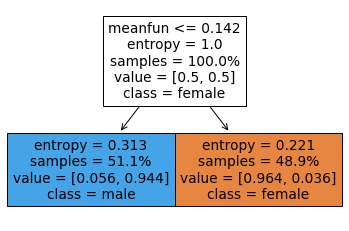

In [69]:
tree.plot_tree(
    decision_tree=dt, #дерево
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    class_names=dt.classes_, #имена классов
);

4. Сделайте предсказание и рассчитайте значение метрики accuracy на тестовой выборке. Ответ округлите до трёх знаков после точки-разделителя.

In [70]:
y_pred = dt.predict(X_test)

print('Accurasy score : {:.3}'.format(
      metrics.accuracy_score(y_test, y_pred)))

Accurasy score : 0.956


### Задание 7.2

Увеличим глубину дерева.

Создайте дерево решений с максимальной глубиной 2. В качестве критерия информативности используйте энтропию Шеннона.

Обучите модель на тренировочной выборке и визуализируйте её в виде графа.

1. Какие факторы используются при построении данного дерева решений?

2. Сколько листьев в построенном дереве содержат в качестве предсказания класс female? Для того, чтобы отобразить имена классов при визуализации дерева решения с помощью функции plot_tree(), укажите параметр class_names=dt.classes_.

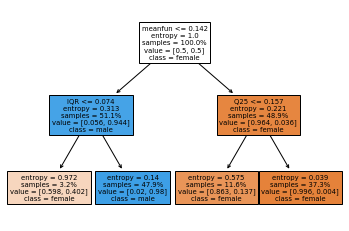

In [71]:
# Создаём модель дерева решений и обучаем её
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=2
)
dt.fit(X_train, y_train)

tree.plot_tree(
    decision_tree=dt, #дерево
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    class_names=dt.classes_, #имена классов
);


3. Сделайте предсказание и рассчитайте значение метрики accuracy на тестовой выборке. Ответ округлите до трёх знаков после точки-разделителя.

In [72]:
y_pred = dt.predict(X_test)

print('Accurasy score : {:.3}'.format(
      metrics.accuracy_score(y_test, y_pred)))

Accurasy score : 0.962


### Задание 7.3

Давайте дадим дереву решений полную свободу.

Создайте дерево решений, не ограничивая его максимальную глубину. В качестве критерия информативности используйте энтропию Шеннона.

В качестве значения параметра random_state возьмите 0.

Обучите модель на тренировочной выборке.

1. Чему равна глубина полученного дерева решения? Напомним, что глубину дерева можно узнать с помощью метода get_depth().

In [73]:
# Создаём модель дерева решений и обучаем её
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=0
    )
dt.fit(X_train, y_train)

dt.get_depth()

12

2. Чему равно количество листьев в полученном дереве решений? Напомним, что количество листьев можно узнать с помощью метода get_n_leaves().

In [74]:
dt.get_n_leaves()

54

3. Сделайте предсказание для обучающей и тестовой выборок и рассчитайте значение метрики accuracy на каждой из выборок. Ответы округлите до трёх знаков после точки-разделителя.

In [75]:
y_pred_train = dt.predict(X_train)

y_pred_test = dt.predict(X_test)

print('Test accurasy score : {:.3}'.format(
      metrics.accuracy_score(y_train, y_pred_train)))

print('Test accurasy score : {:.3}'.format(
      metrics.accuracy_score(y_test, y_pred_test)))

Test accurasy score : 1.0
Test accurasy score : 0.973


### Задание 7.4

Давайте попробуем найти оптимальные внешние параметры модели дерева решений для поставленной задачи. Воспользуемся классическим методом подбора гиперпараметров — перебором на сетке с кросс-валидацией (Grid SearchCV).

Задана следующая сетка параметров:

In [76]:
# Задаём сетку параметров
param_grid = {
    'criterion': ['gini', 'entropy'], #критерий информативности
    'max_depth': [4, 5, 6, 7, 8, 9, 10], #максимальная глубина дерева
    'min_samples_split': [3, 4, 5, 10] #минимальное количество объектов, необходимое для сплита
}

В качестве кросс-валидатора будем использовать k-fold-валидатор со стратификацией (StratifiedKFold):

In [77]:
# Задаём метод кросс-валидации
cv = model_selection.StratifiedKFold(n_splits=5)

С помощью Grid SearchCV из модуля model_selection библиотеки sklearn переберите гиперпараметры дерева решений из приведённой сетки на обучающей выборке и найдите оптимальные. Параметр random_state для дерева решений установите равным 0. В качестве метрики качества (параметр scoring) используйте accuracy.

1. Какой критерий информативности использует наилучшая модель?

2. Чему равна оптимальная максимальная глубина?

3. Чему равно оптимальное минимальное количество объектов, необходимое для разбиения?

In [86]:
from sklearn.model_selection import GridSearchCV

estimator = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=0
    )

gs = GridSearchCV(
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    estimator=estimator
)

gs.fit(X_train, y_train)

gs.best_params_


{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 3}

4. С помощью наилучшей модели сделайте предсказание для обучающей и тестовой выборок. Рассчитайте значение метрики accuracy на каждой из выборок. Ответы округлите до трёх знаков после точки-разделителя.

In [88]:
y_pred_train = gs.best_estimator_.predict(X_train)

y_pred_test = gs.best_estimator_.predict(X_test)


print('Train accurasy score : {:.3}'.format(
      metrics.accuracy_score(y_train, y_pred_train)))

print('Test accurasy score : {:.3}'.format(
      metrics.accuracy_score(y_test, y_pred_test)))

Train accurasy score : 0.996
Test accurasy score : 0.97


### Задание 7.5

Для оптимального дерева решений, построенного в задании 7.4, найдите важность каждого из факторов. Визуализируйте её в виде столбчатой диаграммы.

Выделите топ-3 наиболее важных факторов, участвующих в построении дерева решений:

<AxesSubplot:xlabel='importance', ylabel='feature'>

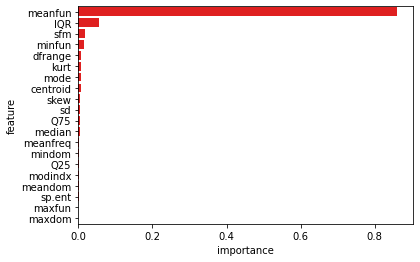

In [159]:
feature_importances = pd.DataFrame(
    data = {'feature' : X.columns, 
            'importance': gs.best_estimator_.feature_importances_},
).sort_values(by='importance', ascending = False)

sns.barplot(
    y=feature_importances['feature'],
    x=feature_importances['importance'],
    orient='h',
    color='red')

# 8. Итоги

✍ Итак, мы рассмотрели алгоритм дерева решений от его корней до самых листьев.

Мы изучили алгоритм CART для построения деревьев и даже самостоятельно реализовали его на Python. Теперь вы понимаете, как обучаются деревья и как они прогнозируют целевую переменную для новых данных как в задачах классификации, так и в задачах регрессии.

Также мы научились определять значимость каждого из признаков, представленных для обучения дерева.

Резюмируя, приведём основные **преимущества** и **недостатки** деревьев:

### Преимущества

* Алгоритм способен решать как задачи классификации, так и задачи регрессии.

* Простой для понимания и интерпретируемый алгоритм, понятный даже людям, не знакомым с машинным обучением. Можно визуализировать в виде графа.

* Не требуется нормализация/стандартизация данных.

* В общем случае деревья могут обрабатывать как числовые, так и категориальные данные. Однако в sklearn категориальные признаки, представленные в нечисловом формате, не поддерживаются.

* Дерево способно решать задачи с несколькими выходами, то есть когда целевая переменная имеет размерность больше 1.

* На основе значимости признаков можно производить их отбор. Однако коэффициенты значимости напрямую зависят от сложности дерева.

### Недостатки

* В силу дискретной топологической структуры дерево не дифференцируется по параметрам — стандартные алгоритмы поиска параметров, такие как градиентный спуск, не работают. Приходится использовать полный перебор, что значительно увеличивает время построения модели, особенно для выборок больших размеров.

* Чрезвычайно сильная склонность к переобучению. Необходим подбор внешних параметров, таких как максимальная глубина, минимальное количество объектов для разделения вершины и других.

* Деревья решений могут быть нестабильными: небольшое изменение в данных способно заметно повлиять на структуру дерева.

* Функция дерева является кусочно-постоянной, поэтому деревья не могут использоваться для экстраполяции (предсказания целевой переменной за границами обучающей выборки).

* Поиск оптимального по структуре дерева решений является NP-полной задачей. Следовательно, практическая реализация дерева решений основана на эвристиках, таких как жадный алгоритм. Он, в свою очередь, не гарантирует того, что дерево будет самым оптимальным.


Как вы уже знаете, от многих из представленных недостатков деревьев можно избавиться, если объединить несколько деревьев в ансамбли. В следующем модуле мы как раз поговорим о математической формализации ансамблевых методов.

Предлагаем вам познакомиться с **дополнительными материалами **по деревьям:

* [Лекция о деревьях решений от ВШЭ](https://www.hse.ru/mirror/pubs/share/215285956)
* [Статья о применении Cost Complexity Pruning](https://medium.com/analytics-vidhya/cost-complexity-pruning-in-decision-trees-f82b14a7fe91) — метода регуляризации деревьев решений путём их обрезки (в sklearn обрезка управляется параметром ccp_alpha)

[Скачайте](https://lms.skillfactory.ru/assets/courseware/v1/44a2ba1611d15fa7e93b7c9a3577e4bd/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/DST_%D0%91%D0%BB%D0%BE%D0%BA_6_%D0%9C%D0%BE%D0%B4%D1%83%D0%BB%D1%8C_MATH_ML-8._%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D1%8C%D0%B5%D0%B2_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9.pdf) конспект к модулю ↓ — он поможет вам лучше структурировать материал и время от времени возвращаться к самым важным понятиям и принципам.